# Top

In [479]:
%matplotlib inline

In [480]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [481]:
import sys
sys.path.append('.')

import pandas as pd
import numpy as np
import incense
from incense import ExperimentLoader
import matplotlib.pyplot as plt
from src import settings

# Print helpers
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import Terminal256Formatter
from pprint import pformat

def save_table(str_, label):
    print(str_)
    with open('thesis_tables/{}.tex'.format(label),'w') as tf:
        tf.write(str_)

def pprint_color(obj):
    print(highlight(pformat(obj), PythonLexer(), Terminal256Formatter()))

In [482]:
import addict
from src.utils import _calc_errors

def get_name(exp_row):
    # Create short hand name for convinience
    name = exp_row['model']
    if exp_row['bo']: 
        name = name + " BO"
    if exp_row['acq'] is not None: 
        name = name + " " + exp_row['acq']
    name = name + " " + exp_row['f']
    return name

def prefix_dict(dict_, prefix):
    return {"{}{}".format(prefix, k): v for k,v in dict_.items()}

def get_exp_key_col(exp):
    """Convert Experiment to pandas row columns.
    """
    config = exp.to_dict()['config']
    config = addict.Dict(config)

    if config.model.name != 'TransformerModel':
        name = config.model.name
    else:
        kwargs = config.model.kwargs
        name = "T<{},{}>".format(kwargs['transformer']['name'], kwargs['prob_model']['name'])
    
    # TODO: Remove custom hack to make f unique when taking parameter D.
    fD = str(config.obj_func.kwargs.get('D', ''))
    
    exp_row = {
        settings.MODEL_HASH: config[settings.MODEL_HASH],
        settings.EXP_HASH: config[settings.EXP_HASH],
        'model': name,
        'model2': config.get('model2', {}).get('name', None),
        'acq': config.get('acquisition_function', {}).get('name'),
        'bo': bool(config.get('bo', None)),
        'f': config['obj_func']['name'] + fD,
        'config': config,
        'tag': config['tag'],
        'exp': exp,
        'id': exp.id,
    }
    # Create short hand name for convinience
    exp_row['name'] = get_name(exp_row)
    
    # Unpack the results as columns
    exp_row.update(prefix_dict(exp.result, 'result.'))
    
    return exp_row


def get_bo_plots(exp):
    return {k: v for k,v in exp.artifacts.items() if k.startswith('bo-plot')}

# ------------- Add entries -----------------

    
def create_baseline(df):
    from src import environments as environments_module
    from runner import unpack, hash_subdict

    functions = df.drop_duplicates(subset='f').apply(lambda r: [r.f, r.config.obj_func, r.config], axis=1)

    baseline_df = pd.DataFrame()
    
    for f_name, func, config in functions:
        name, args, kwargs = unpack(func)
        f = getattr(environments_module, name)(**kwargs)

        # Training samples 
        n_samples = config.gp_samples
        X_train = random_hypercube_samples(n_samples, f.bounds)
        Y_train = f(X_train)

        Y_est = np.mean(Y_train, axis=0)
        mean_estimator = lambda X: np.repeat(Y_est[None,:], X.shape[0], axis=0)
        zero_estimator = lambda X: np.zeros((X.shape[0], 1))
        
        rmse, max_err = _calc_errors(mean_estimator, f.noiseless, f, rand=True, rand_N=10000)

        mean_name = 'mean'
        zero_name = 'zero'
        mean_exp_hash = hash_subdict({'model': mean_name, 'f': func}, keys=['model', 'f'])
        zero_exp_hash = hash_subdict({'model': zero_name, 'f': func}, keys=['model', 'f'])
        
        baseline_df = baseline_df.append([{
            'exp_hash': zero_exp_hash,
            'model_hash': zero_name,
            'model': zero_name,
            'config': config,
            'f': f_name,
            'result.rmse': rmse,
            'result.max_err': max_err,
        }, {
            'exp_hash': mean_exp_hash,
            'model_hash': mean_name,
            'model': mean_name, 
            'config': config,
            'f': f_name,
            'result.rmse': rmse,
            'result.max_err': max_err,
        }])
    
    baseline_df = baseline_df.set_index('exp_hash').sort_index()
    return baseline_df

def create_SG_df(df, depth=3, refinement_level=10, f_tol=1e-3):
    """Runs SG and A-SG for every unique function in `df`.
    Assumes df indexed by exp_hash
    """
    # Performance of SG and A-SG
    functions = df.drop_duplicates(subset='f').apply(lambda r: [r.f, r.config.obj_func, r.config], axis=1)

    # Add SG and A-SG to all f
    from src import environments as environments_module
    from runner import unpack, hash_subdict
    from src.models.asg import AdaptiveSparseGrid

    # Remove multiindex for easy appending
    SG_df = pd.DataFrame()

    for f_name, func, config in functions:
        name, args, kwargs = unpack(func)
        f = getattr(environments_module, name)(**kwargs)

        print("Fitting SG")
        sg = AdaptiveSparseGrid(f, depth=depth, refinement_level=0)
        sg.fit()

        print("Fitting A-SG")
        asg = AdaptiveSparseGrid(f, depth=1, refinement_level=refinement_level, f_tol=f_tol, point_tol=1000)
        asg.fit()

        sg_rmse, sg_max_err = _calc_errors(sg.evaluate, f, f, rand=True)
        asg_rmse, asg_max_err = _calc_errors(asg.evaluate, f, f, rand=True)

        # Hack to create unique exp_hash (unique pr. model,f pair)
        sg_exp_hash = hash_subdict({'model': 'SG', 'f': func}, keys=['model', 'f'])
        asg_exp_hash = hash_subdict({'model': 'A-SG', 'f': func}, keys=['model', 'f'])
        
        SG_df = SG_df.append([{
            'exp_hash': sg_exp_hash,
            'model_hash': 'SG',  # just have to be unique for the model.
            'model': 'SG', 
            'config': config,
            'f': f_name, 
            'result.rmse': sg_rmse,
            'result.max_err': sg_max_err,
            'N': sg.grid.getNumPoints(), 
            'depth': sg.total_depth
        }])
        SG_df = SG_df.append([{
            'exp_hash': asg_exp_hash,
            'model_hash': 'A-SG',
            'model': 'A-SG',
            'config': config,
            'f': f_name, 
            'result.rmse': asg_rmse, 
            'result.max_err': asg_max_err,
            'N': asg.grid.getNumPoints(), 
            'depth': asg.total_depth
        }])

    #SG_df = SG_df.set_index(['model', 'f']).sort_index()
    SG_df = SG_df.set_index('exp_hash').sort_index()
    return SG_df

# -------------- Aggregate ------------------

def aggregate_results(df):
    """Aggregate all results (i.e. final value of metrics)."""
    def agg(col):
        if col.name.startswith('result.'):
            return np.nanmean(col)
        return col.iloc[0]

    return df.reset_index().groupby('exp_hash').agg(agg)

# ------------------ View -------------------

def view_df(df, indexes=['model_hash'], cols=['result.rmse'], f_as_col=False):
    df = df.reset_index().set_index(indexes + ['f']).sort_index()
    df = df[cols]
    if f_as_col:
        return df.unstack('f')
    else:
        return df

def select_experiment_with_rmse(df, rmse, atol=1e-6):
    _ = df[np.isclose(df["result.rmse"], rmse, atol=atol)]
    exp = _.iloc[0].exp

    pprint_color(exp.config)
    for name, artifact in exp.artifacts.items():
        artifact.show()
    return exp

# Show aggregate


In [483]:
import datetime as dt

# Load    
loader = ExperimentLoader(
    mongo_uri=settings.MONGO_DB_URL,
    db_name=settings.MONGO_DB_NAME
)

exps = loader.find({
    'status': 'COMPLETED', 
    'start_time': {
        '$gte': dt.datetime.strptime('2019-05-14T15:24:39.914Z', "%Y-%m-%dT%H:%M:%S.%fZ")}})
        #'$lt': dt.datetime.strptime('2019-05-14T15:24:39.914Z', "%Y-%m-%dT%H:%M:%S.%fZ")}})
exps

[Experiment(id=183, name=lions),
 Experiment(id=186, name=lions),
 Experiment(id=189, name=lions),
 Experiment(id=190, name=lions),
 Experiment(id=191, name=lions),
 Experiment(id=192, name=lions),
 Experiment(id=195, name=lions),
 Experiment(id=196, name=lions),
 Experiment(id=199, name=lions),
 Experiment(id=200, name=lions),
 Experiment(id=201, name=lions),
 Experiment(id=202, name=lions),
 Experiment(id=203, name=lions),
 Experiment(id=204, name=lions),
 Experiment(id=205, name=lions),
 Experiment(id=206, name=lions),
 Experiment(id=207, name=lions),
 Experiment(id=208, name=lions),
 Experiment(id=209, name=lions),
 Experiment(id=210, name=lions),
 Experiment(id=211, name=lions),
 Experiment(id=212, name=lions),
 Experiment(id=213, name=lions),
 Experiment(id=214, name=lions),
 Experiment(id=215, name=lions),
 Experiment(id=216, name=lions),
 Experiment(id=217, name=lions),
 Experiment(id=218, name=lions),
 Experiment(id=220, name=lions),
 Experiment(id=221, name=lions),
 Experimen

In [484]:
#exps = loader.find({'status': 'COMPLETED'})
df = pd.DataFrame([get_exp_key_col(exp) for exp in exps])
df = df.set_index('exp_hash').sort_index()
df

,acq,bo,config,exp,f,id,model,model2,model_hash,name,result.max_err,result.rmse,tag
exp_hash,,,,,,,,,,,,,
01a472c69d6536af485c1e1ac6d1e61123cd6236,None,False,{'exp_hash': '01a472c69d6536af485c1e1ac6d1e611...,"Experiment(id=230, name=lions)",GenzCornerPeak10,230,DKLGPModel,None,c87e307d72937479b09cceca238967c29c663217,DKLGPModel GenzCornerPeak10,4.745757e-12,1.178104e-13,genz
01dc4d606ca69b71b4ee3cf0e1583f7a17ce6a0f,None,False,{'exp_hash': '01dc4d606ca69b71b4ee3cf0e1583f7a...,"Experiment(id=223, name=lions)",GenzContinuous10,223,DKLGPModel,None,c87e307d72937479b09cceca238967c29c663217,DKLGPModel GenzContinuous10,7.575340e-03,2.855601e-04,genz
066baaf72daea88c307aa2581a2a47e1880b4bba,None,False,{'exp_hash': '066baaf72daea88c307aa2581a2a47e1...,"Experiment(id=235, name=lions)",GenzDiscontinuous2,235,DKLGPModel,None,c87e307d72937479b09cceca238967c29c663217,DKLGPModel GenzDiscontinuous2,1.771016e+02,1.752411e+01,genz
08c0c5fd95eadcb6476b5781fb0ae1e27895af74,None,False,{'exp_hash': '08c0c5fd95eadcb6476b5781fb0ae1e2...,"Experiment(id=289, name=lions)",GenzProductPeak10,289,DKLGPModel,None,1e8339e8056442bcc6b089696f8253f2f1909582,DKLGPModel GenzProductPeak10,4.805385e+12,1.857471e+11,genz
0c6422ebe3f59d8416d731b0269d956c3338de45,None,False,{'exp_hash': '0c6422ebe3f59d8416d731b0269d956c...,"Experiment(id=329, name=lions)",SingleStep,329,DKLGPModel,None,f2f80042661a20cfc9b29793e986454810d8d184,DKLGPModel SingleStep,1.594466e+00,5.226019e-02,step
0e0f47c0680a088c894d2e40e140d51090ea45a7,None,False,{'exp_hash': '0e0f47c0680a088c894d2e40e140d510...,"Experiment(id=196, name=lions)",Kink2D,196,"T<ActiveSubspace,DKLGPModel>",None,d1ed1e88f9e664abe71867878c569401a3ae5e2a,"T<ActiveSubspace,DKLGPModel> Kink2D",2.306575e+03,1.410194e+02,embedding
0e0f47c0680a088c894d2e40e140d51090ea45a7,None,False,{'exp_hash': '0e0f47c0680a088c894d2e40e140d510...,"Experiment(id=207, name=lions)",Kink2D,207,"T<ActiveSubspace,DKLGPModel>",None,d1ed1e88f9e664abe71867878c569401a3ae5e2a,"T<ActiveSubspace,DKLGPModel> Kink2D",4.136030e+02,1.266622e+01,embedding
0e368339b59175bcb56073633abe8f27d4414bf0,None,False,{'exp_hash': '0e368339b59175bcb56073633abe8f27...,"Experiment(id=323, name=lions)",SingleStep,323,DKLGPModel,None,e7ad6101a38189c4f2216f49fa3793a4cb195028,DKLGPModel SingleStep,2.219677e+04,6.467302e+03,step
0f40fc8ee4a72f4a62acd4b0b9a92cf646c61e18,None,False,{'exp_hash': '0f40fc8ee4a72f4a62acd4b0b9a92cf6...,"Experiment(id=201, name=lions)",ActiveSubspaceTest,201,"T<ActiveSubspace,DKLGPModel>",None,d1ed1e88f9e664abe71867878c569401a3ae5e2a,"T<ActiveSubspace,DKLGPModel> ActiveSubspaceTest",8.322914e-02,3.311108e-03,embedding


## Plot BO CI

In [23]:
#exps_row = df.loc[df.bo == True].iloc[0]
exps_row = df.loc["60519fa6dbfe5a80969a4b30ddd14cafbf68612f"] # Kink1D
# exps_row = df.loc["75d24ad445d397dbe1a8add031764c707d37cfdf"] # IncreasingOscillationDecreasingAmplitude
exps = exps_row.exps

def get_rmse(exp):
    """Uses old `mse` as fallback."""
    return exp.metrics.get('rmse', exp.metrics.get('mse',pd.Series([])))

def plot_bo_regret(exps, label=None):
    df_concat = pd.concat([get_rmse(exp) for exp in exps], axis=1)
    mean = df_concat.mean(axis=1)
    var = df_concat.var(axis=1)
    plt.plot(df_concat.index, mean, label=label)
    plt.fill_between(df_concat.index, mean - 2 * np.sqrt(var), mean + 2 * np.sqrt(var), alpha=0.2)

KeyError: '60519fa6dbfe5a80969a4b30ddd14cafbf68612f'

In [20]:
# Calculate mean and variance of MSE
# TODO: maybe not silence missing MSE...
plot_bo_regret(exps, label="Regret")
plt.legend()

NameError: name 'plot_bo_regret' is not defined

In [21]:
# Plot all last BO plot
# TODO: plot in grid
for i, exp in enumerate(exps):
    name, last_plot = sorted(get_bo_plots(exp).items())[-1]
    last_plot.show()
    plt.title("Experiment {}:".format(i))

IndexError: list index out of range

## Plot GP final MSE

### Certify ExactDKL

In [138]:
exps_rows_df = df[df["tag"] == "certify-ExactDKL"].copy()

# DKLGPModel
# Pick layers (and convert to tuples for hashability which is required for indexing).
exps_rows_df['layers'] = exps_rows_df.apply(lambda row: row.config.model.kwargs.nn_kwargs.get('layers'), axis=1)
exps_rows_df['layers'] = exps_rows_df.apply(lambda row: tuple(row.layers) if row.layers is not None else (), axis=1)

exps_rows_df['n_iter'] = exps_rows_df.apply(lambda row: row.config.model.kwargs.get('n_iter'), axis=1)
exps_rows_df['learning_rate'] = exps_rows_df.apply(lambda row: row.config.model.kwargs.get('learning_rate'), axis=1)

# GPModel
exps_rows_df['kernel'] = exps_rows_df.apply(lambda row: row.config.model.kwargs.kernel.get('name'), axis=1)
exps_rows_df

ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [116]:
# For this specific `tag` these indexes uniquely determines the model.
exps_rows_df = exps_rows_df.reset_index().set_index(['model', 'n_iter', 'learning_rate', 'f'])
exps_rows_df = exps_rows_df.sort_index()
exps_rows_df

exp_hash  \
model      n_iter learning_rate f                                                     
DKLGPModel 100    0.01          Branin     3e8403dc411b7f7388c3931a136d124cfe8edd7d   
                                Sinc       27807c8cd2c7cdd9f9e83b20194873ab0bf1bb90   
                                TwoKink1D  49a6326b0f86d75e99c2fa4af740794f823ab219   
                  0.05          Branin     058d6232c6cf4d19a2e62d9e39c327366762900c   
                                Sinc       5a820f3269dc0b4fa64506ce35ef8a7bbbe620e7   
                                TwoKink1D  3861ff94600f7fc866de285c0281d299981b5171   
                  0.10          Branin     31d09111f4e6c010c994e84afd41506b4f43f283   
                                Sinc       20716d05eed5faddbc813dbf229314e0e6955c90   
                                TwoKink1D  6a5aa5b0c4c5c25c418f4ac7fc0be44e8e92708d   
           1000   0.01          Branin     d361a65659bf3e6636fce3ed32e9a757fa82fa8d   
                                Sinc       a5eaf714eadb767a3950580007c9c83fad3993ae   
                                TwoKink1D  396328e0912808bb8229cd088f0c6a59d171fec0   
                  0.05          Branin     468ddb1ed3c0c2e125cc7baf57f22ede775bbea7   
                                Sinc       1ea3be78e884ee844376f36b2f8b4caccce6b195   
                                TwoKink1D  066206db16d7cce9384293c4485e9eb08aa1a93c   
                  0.10          Branin     b8fea5654b1e6b3fcc6ee3f2038aedef445dfa99   
                                Sinc       5e30ad2c8a0798f03c4e09bc371bb635f63433b2   
                                TwoKink1D  0a56cbb9d803561f1a67947d5a9c0596a43aae9e   

                                            acq     bo  \
model      n_iter learning_rate f                        
DKLGPModel 100    0.01          Branin     None  False   
                                Sinc       None  False   
                                TwoKink1D  None  False   
                  0.05          Branin     None  False   
                                Sinc       None  False   
                                TwoKink1D  None  False   
                  0.10          Branin     None  False   
                                Sinc       None  False   
                                TwoKink1D  None  False   
           1000   0.01          Branin     None  False   
                                Sinc       None  False   
                                TwoKink1D  None  False   
                  0.05          Branin     None  False   
                                Sinc       None  False   
                                TwoKink1D  None  False   
                  0.10          Branin     None  False   
                                Sinc       None  False   
                                TwoKink1D  None  False   

                                                                                      config  \
model      n_iter learning_rate f                                                              
DKLGPModel 100    0.01          Branin     {'exp_hash': '3e8403dc411b7f7388c3931a136d124c...   
                                Sinc       {'exp_hash': '27807c8cd2c7cdd9f9e83b20194873ab...   
                                TwoKink1D  {'exp_hash': '49a6326b0f86d75e99c2fa4af740794f...   
                  0.05          Branin     {'exp_hash': '058d6232c6cf4d19a2e62d9e39c32736...   
                                Sinc       {'exp_hash': '5a820f3269dc0b4fa64506ce35ef8a7b...   
                                TwoKink1D  {'exp_hash': '3861ff94600f7fc866de285c0281d299...   
                  0.10          Branin     {'exp_hash': '31d09111f4e6c010c994e84afd41506b...   
                                Sinc       {'exp_hash': '20716d05eed5faddbc813dbf229314e0...   
                                TwoKink1D  {'exp_hash': '6a5aa5b0c4c5c25c418f4ac7fc0be44e...   
           1000   0.01          Branin     {'exp_hash': 'd361a65659bf3e6636fce3ed32e9a757...   
                     

In [117]:
# Possible metrics to aggregate and display
RESULT_COLS = list(filter(lambda x: x.startswith("result."), exps_rows_df.columns))
RESULT_COLS

['result.max_err',
 'result.model1:max_err',
 'result.model1:rmse',
 'result.model_compare:mean:max_err',
 'result.model_compare:mean:rmse',
 'result.model_compare:var:max_err',
 'result.model_compare:var:rmse',
 'result.rmse']

In [121]:
# Show aggregate for specific metrics across all functions
# This view makes for easy access to exp_hash.
RESULT = "result.model_compare:mean:rmse"
RESULTS = [
# 'result.rmse',
# 'result.max_err',
# 'result.model1:max_err',
# 'result.model1:rmse',
 'result.model_compare:mean:max_err',
 'result.model_compare:mean:rmse',
 'result.model_compare:var:max_err',
 'result.model_compare:var:rmse',
]

# Aggregate results
exps_rows_df = aggregate_results(exps_rows_df)

# If this throws warning it is because the indexes does not uniquely determind the model
multi_df = exps_rows_df.reset_index().set_index(['model', 'n_iter', 'learning_rate', 'f'])
multi_df = multi_df.sort_index()
multi_df[RESULTS + ['exp_hash']]

result.model_compare:mean:max_err  \
model      n_iter learning_rate f                                              
DKLGPModel 100    0.01          Branin                             41.845051   
                                Sinc                                0.005614   
                                TwoKink1D                           0.011581   
                  0.05          Branin                             15.863464   
                                Sinc                                0.000814   
                                TwoKink1D                           0.007351   
                  0.10          Branin                             26.302370   
                                Sinc                                0.001678   
                                TwoKink1D                           0.004032   
           1000   0.01          Branin                             33.200770   
                                Sinc                                0.000902   
                                TwoKink1D                           0.004317   
                  0.05          Branin                             27.654249   
                                Sinc                                0.001774   
                                TwoKink1D                           0.004245   
                  0.10          Branin                             26.298115   
                                Sinc                                0.001552   
                                TwoKink1D                           0.004302   

                                           result.model_compare:mean:rmse  \
model      n_iter learning_rate f                                           
DKLGPModel 100    0.01          Branin                           2.213217   
                                Sinc                             0.002155   
                                TwoKink1D                        0.004742   
                  0.05          Branin                           1.636808   
                                Sinc                             0.000338   
                                TwoKink1D                        0.001557   
                  0.10          Branin                           1.329572   
                                Sinc                             0.000203   
                                TwoKink1D                        0.000569   
           1000   0.01          Branin                           1.437028   
                                Sinc                             0.000143   
                                TwoKink1D                        0.000562   
                  0.05          Branin                           1.517571   
                                Sinc                             0.000181   
                                TwoKink1D                        0.000581   
                  0.10          Branin                           1.084565   
                                Sinc                             0.000186   
                                TwoKink1D                        0.000629   

                                           result.model_compare:var:max_err  \
model      n_iter learning_rate f                                             
DKLGPModel 100    0.01          Branin                             0.131863   
                                Sinc                               0.011207   
                                TwoKink1D                          0.010258   
                  0.05          Branin                             0.238598   
                                Sinc                               0.010041   
                                TwoKink1D                          0.010013   
                  0.10          Branin                             0.371106   
                                Sinc                               0.010024   
                                TwoKink1D                          0.010043   
           1000   0.01          

In [122]:
# View that put function in multiindexed column
multi_df[RESULTS].reset_index().groupby(['model', 'n_iter', 'learning_rate']).agg('mean')

result.model_compare:mean:max_err  \
model      n_iter learning_rate                                      
DKLGPModel 100    0.01                                   13.954082   
                  0.05                                    5.290543   
                  0.10                                    8.769360   
           1000   0.01                                   11.068663   
                  0.05                                    9.220089   
                  0.10                                    8.767990   

                                 result.model_compare:mean:rmse  \
model      n_iter learning_rate                                   
DKLGPModel 100    0.01                                 0.740038   
                  0.05                                 0.546234   
                  0.10                                 0.443448   
           1000   0.01                                 0.479244   
                  0.05                                 0.506111   
                  0.10                                 0.361793   

                                 result.model_compare:var:max_err  \
model      n_iter learning_rate                                     
DKLGPModel 100    0.01                                   0.051109   
                  0.05                                   0.086217   
                  0.10                                   0.130391   
           1000   0.01                                   0.076848   
                  0.05                                   0.399433   
                  0.10                                   0.283409   

                                 result.model_compare:var:rmse  
model      n_iter learning_rate                                 
DKLGPModel 100    0.01                                0.009856  
                  0.05                                0.012824  
                  0.10                                0.014144  
           1000   0.01                                0.012274  
                  0.05                                0.021005  
                  0.10                                0.025621

In [123]:
# View that put function in multiindexed column
multi_df[RESULTS].sort_index().unstack('f')

result.model_compare:mean:max_err            \
f                                                          Branin      Sinc   
model      n_iter learning_rate                                               
DKLGPModel 100    0.01                                  41.845051  0.005614   
                  0.05                                  15.863464  0.000814   
                  0.10                                  26.302370  0.001678   
           1000   0.01                                  33.200770  0.000902   
                  0.05                                  27.654249  0.001774   
                  0.10                                  26.298115  0.001552   

                                          result.model_compare:mean:rmse  \
f                               TwoKink1D                         Branin   
model      n_iter learning_rate                                            
DKLGPModel 100    0.01           0.011581                       2.213217   
                  0.05           0.007351                       1.636808   
                  0.10           0.004032                       1.329572   
           1000   0.01           0.004317                       1.437028   
                  0.05           0.004245                       1.517571   
                  0.10           0.004302                       1.084565   

                                                     \
f                                    Sinc TwoKink1D   
model      n_iter learning_rate                       
DKLGPModel 100    0.01           0.002155  0.004742   
                  0.05           0.000338  0.001557   
                  0.10           0.000203  0.000569   
           1000   0.01           0.000143  0.000562   
                  0.05           0.000181  0.000581   
                  0.10           0.000186  0.000629   

                                result.model_compare:var:max_err            \
f                                                         Branin      Sinc   
model      n_iter learning_rate                                              
DKLGPModel 100    0.01                                  0.131863  0.011207   
                  0.05                                  0.238598  0.010041   
                  0.10                                  0.371106  0.010024   
           1000   0.01                                  0.210501  0.010009   
                  0.05                                  1.178263  0.010002   
                  0.10                                  0.830189  0.010009   

                                          result.model_compare:var:rmse  \
f                               TwoKink1D                        Branin   
model      n_iter learning_rate                                           
DKLGPModel 100    0.01           0.010258                      0.010239   
                  0.05           0.010013                      0.018486   
                  0.10           0.010043                      0.022434   
           1000   0.01           0.010033                      0.016829   
                  0.05           0.010036                      0.043013   
                  0.10           0.010030                      0.056863   

                                                     
f                                    Sinc TwoKink1D  
model      n_iter learning_rate                      
DKLGPModel 100    0.01           0.009306  0.010022  
                  0.05           0.009984  0.010002  
                  0.10           0.009998  0.010000  
           1000   0.01           0.009993  0.010001  
                  0.05           0.010000  0.010001  
                  0.10           0.010000  0.010000

In [124]:
# \label{table:dkl-identity}
temp_df = multi_df.reset_index().set_index(['n_iter', 'learning_rate', 'f'])[RESULTS].sort_index().unstack('f')
temp_df = temp_df.copy()
temp_df = temp_df.rename(
    columns={
        'result.model_compare:mean:max_err': '$\mu\ L_\infty$',
        'result.model_compare:mean:rmse': '$\mu\ L_2$',
        'result.model_compare:var:max_err': '$\sigma\ L_\infty$',
        'result.model_compare:var:rmse': '$\sigma\ L_2$'
})
temp_df = temp_df.set_index(temp_df.index.set_names(['Learning rate', 'Epochs']))
save_table(temp_df.to_latex(escape=False), 'dkl-identity')
temp_df

\begin{tabular}{llrrrrrrrrrrrr}
\toprule
     & {} & \multicolumn{3}{l}{$\mu\ L_\infty$} & \multicolumn{3}{l}{$\mu\ L_2$} & \multicolumn{3}{l}{$\sigma\ L_\infty$} & \multicolumn{3}{l}{$\sigma\ L_2$} \\
     & f &          Branin &      Sinc & TwoKink1D &     Branin &      Sinc & TwoKink1D &             Branin &      Sinc & TwoKink1D &        Branin &      Sinc & TwoKink1D \\
Learning rate & Epochs &                 &           &           &            &           &           &                    &           &           &               &           &           \\
\midrule
100  & 0.01 &       41.845051 &  0.005614 &  0.011581 &   2.213217 &  0.002155 &  0.004742 &           0.131863 &  0.011207 &  0.010258 &      0.010239 &  0.009306 &  0.010022 \\
     & 0.05 &       15.863464 &  0.000814 &  0.007351 &   1.636808 &  0.000338 &  0.001557 &           0.238598 &  0.010041 &  0.010013 &      0.018486 &  0.009984 &  0.010002 \\
     & 0.10 &       26.302370 &  0.001678 &  0.004032 &   1.32957

$\mu\ L_\infty$                     $\mu\ L_2$            \
f                             Branin      Sinc TwoKink1D     Branin      Sinc   
Learning rate Epochs                                                            
100           0.01         41.845051  0.005614  0.011581   2.213217  0.002155   
              0.05         15.863464  0.000814  0.007351   1.636808  0.000338   
              0.10         26.302370  0.001678  0.004032   1.329572  0.000203   
1000          0.01         33.200770  0.000902  0.004317   1.437028  0.000143   
              0.05         27.654249  0.001774  0.004245   1.517571  0.000181   
              0.10         26.298115  0.001552  0.004302   1.084565  0.000186   

                               $\sigma\ L_\infty$                      \
f                    TwoKink1D             Branin      Sinc TwoKink1D   
Learning rate Epochs                                                    
100           0.01    0.004742           0.131863  0.011207  0.010258   
              0.05    0.001557           0.238598  0.010041  0.010013   
              0.10    0.000569           0.371106  0.010024  0.010043   
1000          0.01    0.000562           0.210501  0.010009  0.010033   
              0.05    0.000581           1.178263  0.010002  0.010036   
              0.10    0.000629           0.830189  0.010009  0.010030   

                     $\sigma\ L_2$                      
f                           Branin      Sinc TwoKink1D  
Learning rate Epochs                                    
100           0.01        0.010239  0.009306  0.010022  
              0.05        0.018486  0.009984  0.010002  
              0.10        0.022434  0.009998  0.010000  
1000          0.01        0.016829  0.009993  0.010001  
              0.05        0.043013  0.010000  0.010001  
              0.10        0.056863  0.010000  0.010000

In [125]:
functions = exps_rows_df['f'].unique()
functions

array(['Branin', 'TwoKink1D', 'Sinc'], dtype=object)

9
16
2


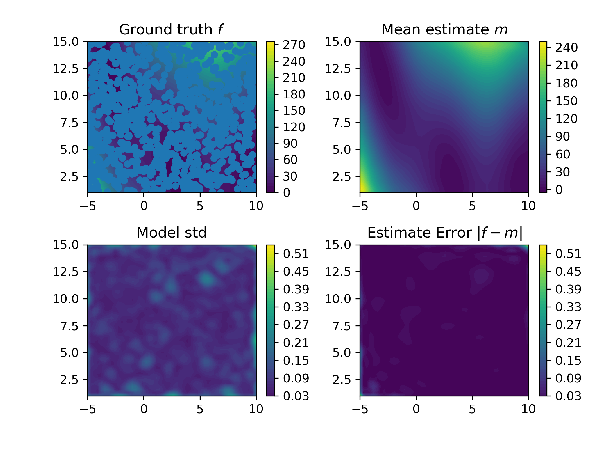

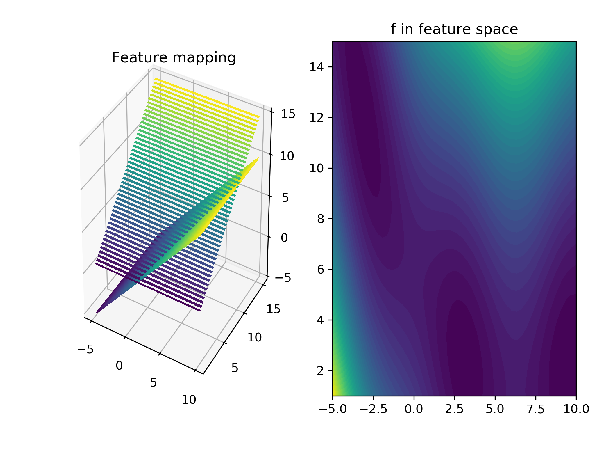

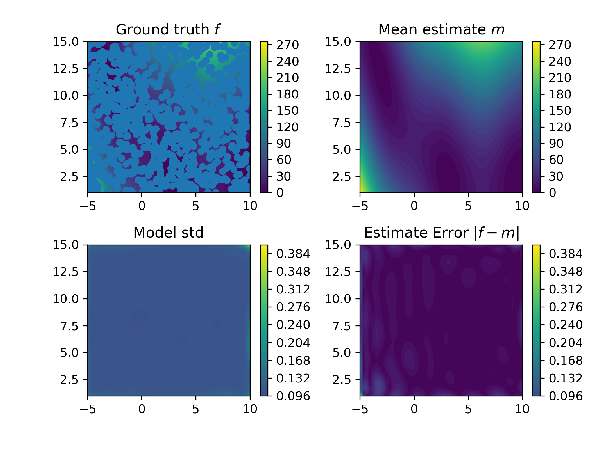

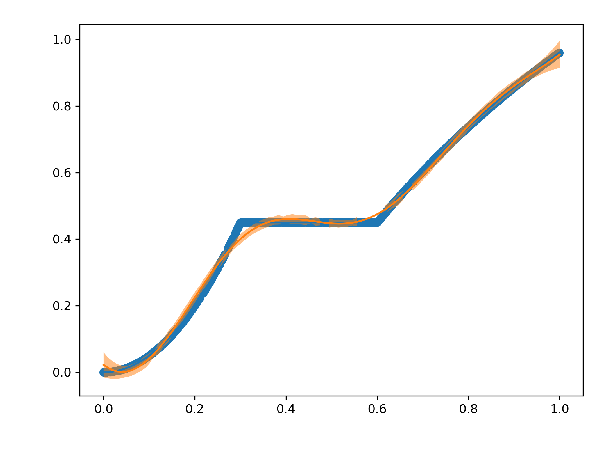

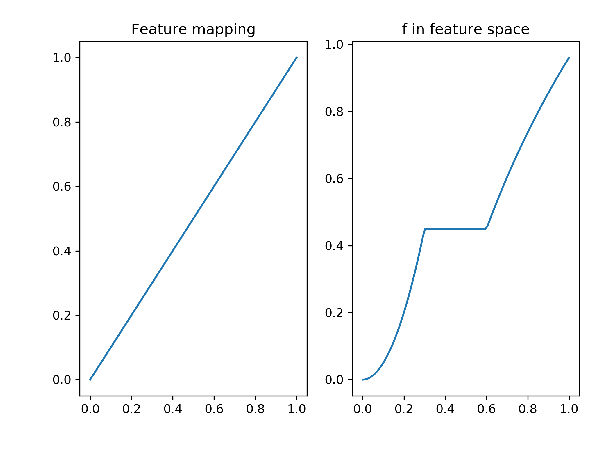

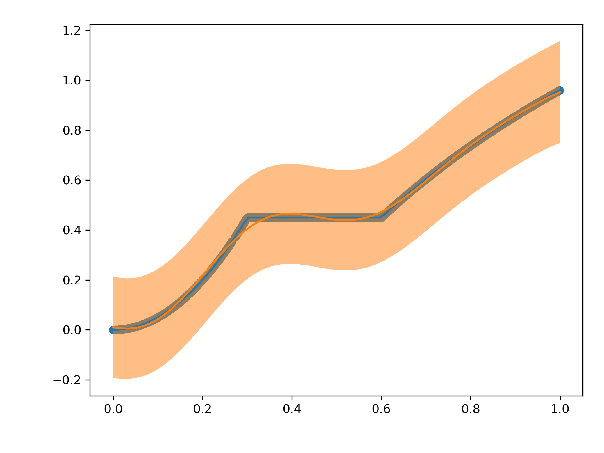

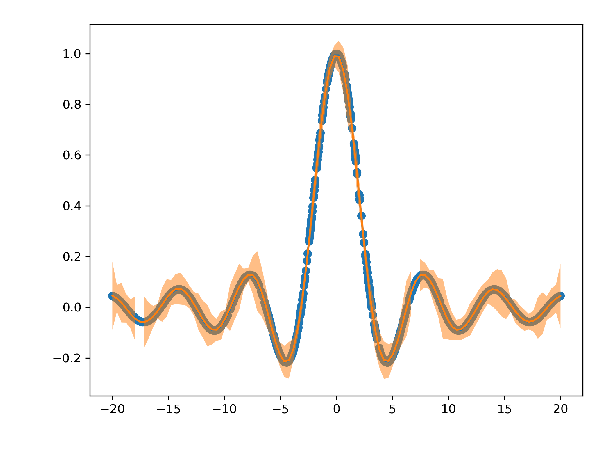

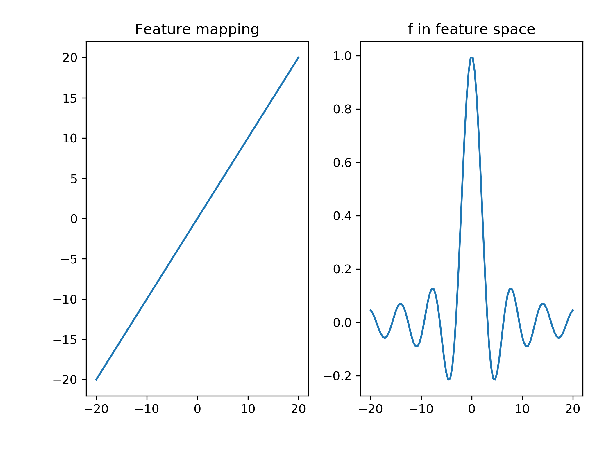

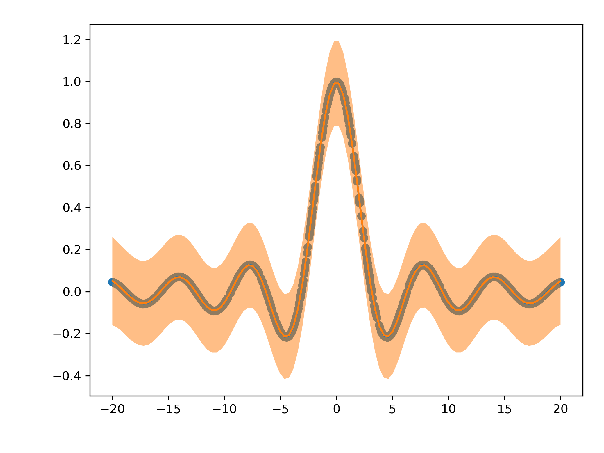

In [126]:
# (pick exp_hash and plot artifacts)
for func in functions:
    temp_df = exps_rows_df[exps_rows_df['f'] == func]               # for a given function
    max_idx = temp_df['result.model_compare:mean:max_err'].idxmax() # find the model with max err
    exp_row = temp_df.loc[max_idx]                                  # grab that model

    exp = exp_row.exp
    print(exp._id)
    for name, artifact in exp.artifacts.items():
        artifact.show()

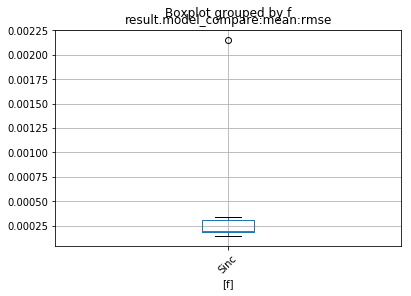

In [128]:
# Box plot for fixed RESULT with MODEL marginalised (WATCH OUT that we dont agg too many models!)
temp_df = temp_df.reset_index().set_index('f')
temp_df[[RESULT]].boxplot(by='f', rot=45)

### Hyperparam opt of DKL

In [129]:
exps_rows_df = df[df["tag"] == "DKL-properties"].copy()
exps_rows_df.set_index('model_hash').sort_index()

,acq,bo,config,exp,f,id,model,model2,name,result.max_err,result.model1:max_err,result.model1:rmse,result.model_compare:mean:max_err,result.model_compare:mean:rmse,result.model_compare:var:max_err,result.model_compare:var:rmse,result.rmse,tag
model_hash,,,,,,,,,,,,,,,,,,
0a932a10f0b536285918bd94254713ac9ce05752,None,False,{'exp_hash': 'cc78820b89ab2c58b99b34e05729e993...,"Experiment(id=128, name=lions)",TwoKink2D,128,DKLGPModel,None,DKLGPModel TwoKink2D,0.091692,NaN,NaN,NaN,NaN,NaN,NaN,0.018355,DKL-properties
0a932a10f0b536285918bd94254713ac9ce05752,None,False,{'exp_hash': '81d9c5e611d9124dbe0a872719bb7d99...,"Experiment(id=150, name=lions)",TwoKinkDEmbedding2,150,DKLGPModel,None,DKLGPModel TwoKinkDEmbedding2,0.043982,NaN,NaN,NaN,NaN,NaN,NaN,0.009472,DKL-properties
0a932a10f0b536285918bd94254713ac9ce05752,None,False,{'exp_hash': '89c95c124823db0f135e24a5e1cdc3ed...,"Experiment(id=84, name=lions)",Kink2D,84,DKLGPModel,None,DKLGPModel Kink2D,2.220672,NaN,NaN,NaN,NaN,NaN,NaN,0.230515,DKL-properties
0a932a10f0b536285918bd94254713ac9ce05752,None,False,{'exp_hash': 'b06d0d06bb9001511f52a80f3a808c53...,"Experiment(id=64, name=lions)",Kink1D,64,DKLGPModel,None,DKLGPModel Kink1D,9631.613513,NaN,NaN,NaN,NaN,NaN,NaN,635.244723,DKL-properties
0a932a10f0b536285918bd94254713ac9ce05752,None,False,{'exp_hash': 'cc66315b4b9a062e9db4ace0db793d5b...,"Experiment(id=106, name=lions)",TwoKink1D,106,DKLGPModel,None,DKLGPModel TwoKink1D,0.043620,NaN,NaN,NaN,NaN,NaN,NaN,0.010110,DKL-properties
0abdcf13c60d633160931867b5c8a04774f1e00f,None,False,{'exp_hash': 'd14b3f624f26d4a40cd6dc2996018559...,"Experiment(id=92, name=lions)",TwoKink1D,92,DKLGPModel,None,DKLGPModel TwoKink1D,0.030290,NaN,NaN,NaN,NaN,NaN,NaN,0.006613,DKL-properties
0abdcf13c60d633160931867b5c8a04774f1e00f,None,False,{'exp_hash': '7892754f4c4243717a7bcc5f5652ffe8...,"Experiment(id=70, name=lions)",Kink2D,70,DKLGPModel,None,DKLGPModel Kink2D,7.497409,NaN,NaN,NaN,NaN,NaN,NaN,1.117372,DKL-properties
0abdcf13c60d633160931867b5c8a04774f1e00f,None,False,{'exp_hash': '915933db4ddb4e9d1f861828304361ed...,"Experiment(id=114, name=lions)",TwoKink2D,114,DKLGPModel,None,DKLGPModel TwoKink2D,0.089232,NaN,NaN,NaN,NaN,NaN,NaN,0.015372,DKL-properties
0abdcf13c60d633160931867b5c8a04774f1e00f,None,False,{'exp_hash': 'f8c0f9d20caab7407462076b47505db7...,"Experiment(id=135, name=lions)",TwoKinkDEmbedding2,135,DKLGPModel,None,DKLGPModel TwoKinkDEmbedding2,0.046023,NaN,NaN,NaN,NaN,NaN,NaN,0.009454,DKL-properties


In [130]:
# We sort averaged RMSE across functions for each model config.
model_rmse_df = exps_rows_df[exps_rows_df['model'] == 'DKLGPModel']

model_rmse_df['layers'] = model_rmse_df.apply(lambda row: row.config.model.kwargs.nn_kwargs.get('layers'), axis=1)
model_rmse_df['layers'] = model_rmse_df.apply(lambda row: tuple(row.layers) if row.layers is not None else (), axis=1)
model_rmse_df['n_iter'] = model_rmse_df.apply(lambda row: row.config.model.kwargs.get('n_iter'), axis=1)
model_rmse_df['learning_rate'] = model_rmse_df.apply(lambda row: row.config.model.kwargs.get('learning_rate'), axis=1)

# Average
model_rmse_df = model_rmse_df.groupby('model_hash').agg({
    'layers': 'first',
    'n_iter': 'first',
    'learning_rate': 'first',
    'result.rmse': np.nanmean, 
    'f': 'count'
})
model_rmse_df = model_rmse_df.sort_values('result.rmse')
model_rmse_df

,layers,n_iter,learning_rate,result.rmse,f
model_hash,,,,,
c8fda2c1c158956119b0186ae116789c8e7e4ba6,"(100, 50, 2)",100,0.01,1.803034,5
b7d7bb41c0520c6648b45cb5351e420528c64cf4,"(50, 2)",1000,0.05,1.826364,5
0abdcf13c60d633160931867b5c8a04774f1e00f,"(100, 50, 1)",100,0.01,1.838556,5
9cc8030b395bad4d72a656f9de29b4ed622f714b,"(50, 2)",1000,0.01,3.159017,5
4fc93576c52242b5b57558ecb50f3a008d7d38e6,"(100, 50, 1)",1000,0.10,3.358059,5
69d93e37bc7eaad4a591c3b983f798dbeca313ff,(),1000,NaN,4.509213,5
da9fb227bfaeb52cfdd499e32ce6376cb7cfa21c,"(50, 2)",100,0.05,7.830038,5
e5fc834dc45c3a0d3a9caa67974e5f4ffca43f91,(),100,NaN,8.189735,5
0cf0cbd7a7c05d6541936958b5ba09c049c9c642,"(50, 2)",100,0.01,9.423027,5


In [40]:
# Pick the DKL model with minimum RMSE across all functions.
model_hash = model_rmse_df['result.rmse'].idxmin()
model = exps_rows_df[exps_rows_df['model_hash'] == model_hash].iloc[0]
model

acq                                                                               None
bo                                                                               False
config                               {'exp_hash': 'f3a01169859bd9087845e5d62c331393...
exp                                                      Experiment(id=47, name=lions)
f                                                                               Kink1D
model                                                                       DKLGPModel
model2                                                                            None
model_hash                                    c8fda2c1c158956119b0186ae116789c8e7e4ba6
name                                                                 DKLGPModel Kink1D
result.max_err                                                                 200.293
result.model1:max_err                                                              NaN
result.model1:rmse                         

In [262]:
pprint_color(model.config)

{'exp_hash': 'f3a01169859bd9087845e5d62c331393a57f4a5a',
 'gp_samples': 1000,
 'gp_use_derivatives': False,
 'model': {'kwargs': {'learning_rate': 0.01,
                      'n_iter': 100,
                      'nn_kwargs': {'layers': [100, 50, 2]},
                      'noise': 0.01},
           'name': 'DKLGPModel'},
 'model_compare': False,
 'model_hash': 'c8fda2c1c158956119b0186ae116789c8e7e4ba6',
 'obj_func': {'name': 'Kink1D'},
 'seed': 284414934,
 'tag': 'DKL-properties',
 'verbosity': {'bo_show_iter': 30, 'plot': False}}



In [263]:
# Make a nice latex version
# \label{table:dkl-hyperparams}
model_rmse_tex_df = model_rmse_df.reset_index().set_index(['layers', 'n_iter', 'learning_rate'])[['result.rmse']].sort_index()
model_rmse_tex_df = model_rmse_tex_df.set_index(model_rmse_tex_df.index.rename(['Layers', 'Epochs', 'Learning rate']))
model_rmse_tex_df = model_rmse_tex_df.rename(columns={'result.rmse': '$L_2$'})
save_table(model_rmse_tex_df.to_latex(escape=False), 'dkl-hyperparams')
model_rmse_tex_df

\begin{tabular}{lllr}
\toprule
             &      &      &        $L_2$ \\
Layers & Epochs & Learning rate &              \\
\midrule
() & 100  & NaN &     8.189735 \\
             & 1000 & NaN &     4.509213 \\
(50, 2) & 100  & 0.01 &     9.423027 \\
             &      & 0.05 &     7.830038 \\
             &      & 0.10 &   133.263154 \\
             & 1000 & 0.01 &     3.159017 \\
             &      & 0.05 &     1.826364 \\
             &      & 0.10 &   127.102635 \\
(100, 50, 1) & 100  & 0.01 &     1.838556 \\
             &      & 0.05 &   762.801642 \\
             &      & 0.10 &    46.942766 \\
             & 1000 & 0.01 &  7043.646085 \\
             &      & 0.05 &  1891.771787 \\
             &      & 0.10 &     3.358059 \\
(100, 50, 2) & 100  & 0.01 &     1.803034 \\
             &      & 0.05 &    16.075903 \\
             &      & 0.10 &   140.842526 \\
             & 1000 & 0.01 &    10.568410 \\
             &      & 0.05 &   119.360991 \\
             &      & 0.10 

$L_2$
Layers       Epochs Learning rate             
()           100    NaN               8.189735
             1000   NaN               4.509213
(50, 2)      100    0.01              9.423027
                    0.05              7.830038
                    0.10            133.263154
             1000   0.01              3.159017
                    0.05              1.826364
                    0.10            127.102635
(100, 50, 1) 100    0.01              1.838556
                    0.05            762.801642
                    0.10             46.942766
             1000   0.01           7043.646085
                    0.05           1891.771787
                    0.10              3.358059
(100, 50, 2) 100    0.01              1.803034
                    0.05             16.075903
                    0.10            140.842526
             1000   0.01             10.568410
                    0.05            119.360991
                    0.10            103.245766

### Properties

In [148]:
exps_rows_df = df[df["tag"] == "DKL-properties"].copy()
exps_rows_df

,acq,bo,config,exp,f,id,model,model2,model_hash,name,result.max_err,result.rmse,tag
exp_hash,,,,,,,,,,,,,


In [149]:
# select EXP_HASH
# We learn embedding. But what about lengthscale? Try on 1D where lengthscale is varying.

exp_row = exps_rows_df.loc['4962f94147e32bc49605621d0c9232bc519dd75a']
exp = exp_row.iloc[0].exp
pprint_color(exp.config)
for name, artifact in exp.artifacts.items():
    artifact.show()

KeyError: '4962f94147e32bc49605621d0c9232bc519dd75a'

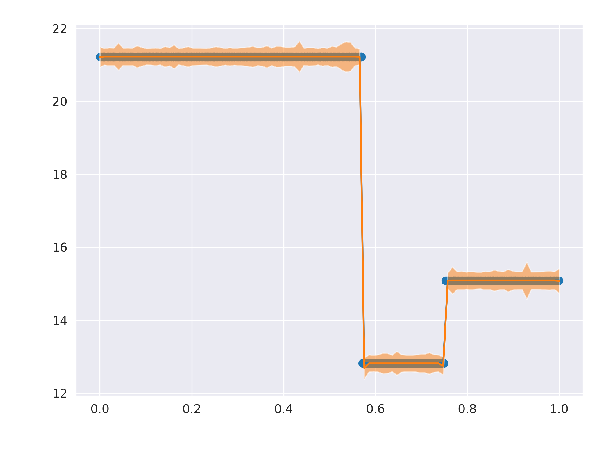

In [115]:
exp = exps_rows_df.loc['1140aeabb548f878cd07592d2061cbcde1e4012a']
exp = exp.exps[0]
for name, artifact in exp.artifacts.items():
    artifact.show()

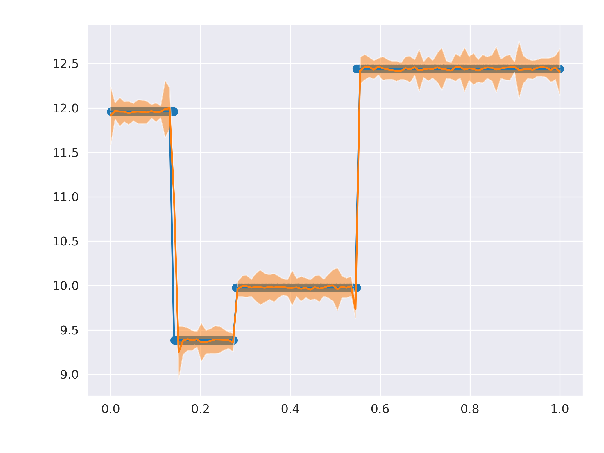

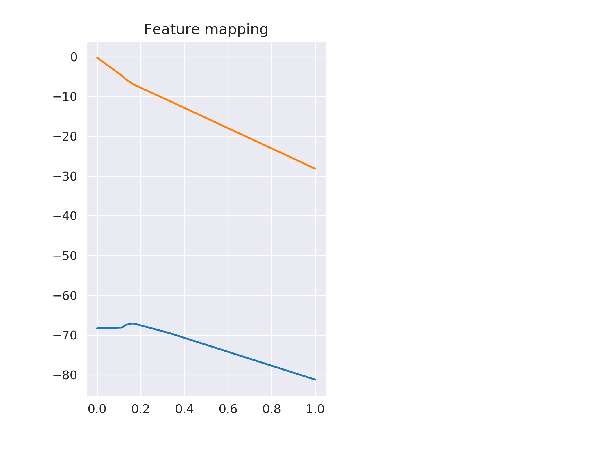

In [113]:
exp = exps_rows_df.loc['5173104e348f102cf1478d6066119d4d23293a79']
exp = exp.exps[0]
for name, artifact in exp.artifacts.items():
    artifact.show()

### Non-stationarity in low dim

In [153]:
exps_rows_df = df[df["tag"] == "DKL-properties"].copy()
exps_rows_df

,acq,bo,config,exp,f,id,model,model2,model_hash,name,result.max_err,result.model1:max_err,result.model1:rmse,result.model_compare:mean:max_err,result.model_compare:mean:rmse,result.model_compare:var:max_err,result.model_compare:var:rmse,result.rmse,tag
exp_hash,,,,,,,,,,,,,,,,,,,
012a2b5cb4ab03c1bfd47807742a0463b7fe1740,None,False,{'exp_hash': '012a2b5cb4ab03c1bfd47807742a0463...,"Experiment(id=133, name=lions)",TwoKinkDEmbedding2,133,DKLGPModel,None,c60b9225f9034e2b17458ebfe4f2cd455806f8d6,DKLGPModel TwoKinkDEmbedding2,0.043438,NaN,NaN,NaN,NaN,NaN,NaN,0.007867,DKL-properties
054b005191c3e0339a0b632abb05f8e867dba739,None,False,{'exp_hash': '054b005191c3e0339a0b632abb05f8e8...,"Experiment(id=104, name=lions)",TwoKink1D,104,DKLGPModel,None,4fc93576c52242b5b57558ecb50f3a008d7d38e6,DKLGPModel TwoKink1D,0.032783,NaN,NaN,NaN,NaN,NaN,NaN,0.009130,DKL-properties
063dfefe784a0babbea92e7f2747ac9322a61002,None,False,{'exp_hash': '063dfefe784a0babbea92e7f2747ac93...,"Experiment(id=88, name=lions)",TwoKink1D,88,DKLGPModel,None,69d93e37bc7eaad4a591c3b983f798dbeca313ff,DKLGPModel TwoKink1D,0.044376,NaN,NaN,NaN,NaN,NaN,NaN,0.010431,DKL-properties
09338db22ede4ec7ca103b462dfa2c111d6831bc,None,False,{'exp_hash': '09338db22ede4ec7ca103b462dfa2c11...,"Experiment(id=60, name=lions)",Kink1D,60,DKLGPModel,None,9cc8030b395bad4d72a656f9de29b4ed622f714b,DKLGPModel Kink1D,386.811689,NaN,NaN,NaN,NaN,NaN,NaN,15.594846,DKL-properties
10c65b48190b6e65ca86957e92eeacdf3035082e,None,False,{'exp_hash': '10c65b48190b6e65ca86957e92eeacdf...,"Experiment(id=91, name=lions)",TwoKink1D,91,DKLGPModel,None,da9fb227bfaeb52cfdd499e32ce6376cb7cfa21c,DKLGPModel TwoKink1D,0.030291,NaN,NaN,NaN,NaN,NaN,NaN,0.007192,DKL-properties
118e30d81be48006428d68ff6daf24464cbb1a1d,None,False,{'exp_hash': '118e30d81be48006428d68ff6daf2446...,"Experiment(id=53, name=lions)",Kink1D,53,DKLGPModel,None,c473c83a1dbd3eeb3c3a2c0f2112868f4d2c0478,DKLGPModel Kink1D,9989.913026,NaN,NaN,NaN,NaN,NaN,NaN,665.959308,DKL-properties
1191c9375be8d0cc5958ab6d1a301ce3807fa32a,None,False,{'exp_hash': '1191c9375be8d0cc5958ab6d1a301ce3...,"Experiment(id=77, name=lions)",Kink2D,77,DKLGPModel,None,419b81b2b5c982e4a17253a8843426371482b6fb,DKLGPModel Kink2D,1.629086,NaN,NaN,NaN,NaN,NaN,NaN,0.133583,DKL-properties
1274e46ef2827585af3bd1f35711aca804281410,None,False,{'exp_hash': '1274e46ef2827585af3bd1f35711aca8...,"Experiment(id=98, name=lions)",TwoKink1D,98,DKLGPModel,None,6edd86b32b86bf5f880265a4a887ebf3185ad2b6,DKLGPModel TwoKink1D,0.019366,NaN,NaN,NaN,NaN,NaN,NaN,0.005822,DKL-properties
163855d60a5ba13d0f747f3be1a4d2fa274a1ea9,None,False,{'exp_hash': '163855d60a5ba13d0f747f3be1a4d2fa...,"Experiment(id=131, name=lions)",TwoKinkDEmbedding2,131,DKLGPModel,None,e5fc834dc45c3a0d3a9caa67974e5f4ffca43f91,DKLGPModel TwoKinkDEmbedding2,0.058594,NaN,NaN,NaN,NaN,NaN,NaN,0.014247,DKL-properties


In [177]:
# DKLModel
dkl_df = exps_rows_df[exps_rows_df['model'] == 'DKLGPModel']

dkl_df['layers'] = dkl_df.apply(lambda row: row.config.model.kwargs.nn_kwargs.get('layers'), axis=1)
dkl_df['layers'] = dkl_df.apply(lambda row: tuple(row.layers) if row.layers is not None else (), axis=1)
dkl_df['n_iter'] = dkl_df.apply(lambda row: row.config.model.kwargs.get('n_iter'), axis=1)
dkl_df['learning_rate'] = dkl_df.apply(lambda row: row.config.model.kwargs.get('learning_rate'), axis=1)

dkl_df = aggregate_results(dkl_df)

dkl_df.set_index(['layers', 'n_iter', 'learning_rate', 'f']).sort_values('result.rmse').sort_index()['result.rmse'].unstack('f')

f                                       Kink1D        Kink2D  TwoKink1D  \
layers       n_iter learning_rate                                         
()           100    NaN              40.564451      0.340182   0.010807   
             1000   NaN              22.261545      0.241523   0.010431   
(50, 2)      100    0.01             46.833457      0.245758   0.003105   
                    0.05             38.854175      0.259719   0.007192   
                    0.10            665.959308      0.319627   0.008811   
             1000   0.01             15.594846      0.175867   0.002129   
                    0.05              8.961886      0.149103   0.004047   
                    0.10            635.244723      0.230515   0.010110   
(100, 50, 1) 100    0.01              8.043969      1.117372   0.006613   
                    0.05            134.372790   3679.609431   0.006813   
                    0.10             32.934717    201.671027   0.008772   
             1000   0.01             19.029000  35199.185020   0.002050   
                    0.05           9123.170546    335.663872   0.005822   
                    0.10             14.214432      2.531896   0.009130   
(100, 50, 2) 100    0.01              8.797606      0.190712   0.003573   
                    0.05             78.439449      1.912683   0.004806   
                    0.10            703.212399      0.962892   0.009263   
             1000   0.01             52.721589      0.103437   0.002899   
                    0.05            596.646663      0.133583   0.006074   
                    0.10            514.400083      1.803077   0.006397   

f                                  TwoKink2D  TwoKinkDEmbedding2  
layers       n_iter learning_rate                                 
()           100    NaN             0.018990            0.014247  
             1000   NaN             0.018778            0.013787  
(50, 2)      100    0.01            0.020999            0.011813  
                    0.05            0.019159            0.009944  
                    0.10            0.016811            0.011213  
             1000   0.01            0.014711            0.007532  
                    0.05            0.011130            0.005657  
                    0.10            0.018355            0.009472  
(100, 50, 1) 100    0.01            0.015372            0.009454  
                    0.05            0.011307            0.007867  
                    0.10            0.062403            0.036911  
             1000   0.01            0.009799            0.004557  
                    0.05            0.013115            0.005580  
                    0.10            0.027594            0.007243  
(100, 50, 2) 100    0.01            0.013322            0.009958  
                    0.05            0.011888            0.010691  
                    0.10            0.018074            0.010003  
             1000   0.01            0.008708            0.005417  
                    0.05            0.011862            0.006774  
                    0.10            0.011852            0.007422

In [159]:
# GPModel
gp_df = exps_rows_df[exps_rows_df['model'] == 'GPModel']

gp_df['kernel'] = gp_df.apply(lambda row: row.config.model.kwargs.kernel.name, axis=1)

gp_df = aggregate_results(gp_df)
gp_df.set_index(['kernel', 'f']).sort_values('result.rmse').sort_index()['result.rmse'].unstack('f')

f,Kink1D,Kink2D,TwoKink1D,TwoKink2D,TwoKinkDEmbedding2
kernel,,,,,
GPyMatern32,7.548232,0.226828,0.005441,0.016530,0.010103
GPyRBF,8.565553,0.313265,0.010500,0.020283,0.016816


In [172]:
# SG models
SG_df = create_SG_df(exps_rows_df, depth=10, refinement_level=12, f_tol=1e-4)
SG_df.reset_index().set_index(['model_hash', 'f'])[['result.rmse']].unstack('f')

Fitting SG
Fitting A-SG
Fitting SG
Fitting A-SG
Fitting SG
Fitting A-SG
Fitting SG
Fitting A-SG
Fitting SG
Fitting A-SG


result.rmse                                                 
f               Kink1D    Kink2D TwoKink1D TwoKink2D TwoKinkDEmbedding2
model_hash                                                             
A-SG          0.213211  0.293698  0.000010  0.003577           0.001291
SG            9.782623  0.080758  0.000009  0.001220           0.000821

In [179]:
# Stitch together with exp_hash as index
dkl_mod_df = dkl_df
dkl_mod_df['name'] = dkl_mod_df[['layers', 'n_iter', 'learning_rate']].apply(tuple, axis=1)
dkl_mod_df = dkl_mod_df[dkl_mod_df['name'] == ((100, 50, 2), 1000, 0.01)]

gp_mod_df = gp_df
gp_mod_df['name'] = gp_mod_df['kernel']

SG_mod_df = SG_df
SG_mod_df['name'] = SG_mod_df['model']

# Convert to nice view
non_stat_df = pd.concat([dkl_mod_df, gp_mod_df, SG_mod_df])
non_stat_df = non_stat_df.reset_index().set_index(['name', 'f'])[['result.rmse']].unstack('f')
non_stat_df

result.rmse                                \
f                               Kink1D    Kink2D TwoKink1D TwoKink2D   
name                                                                   
((100, 50, 2), 1000, 0.01)   52.721589  0.103437  0.002899  0.008708   
A-SG                          0.213211  0.293698  0.000010  0.003577   
GPyMatern32                   7.548232  0.226828  0.005441  0.016530   
GPyRBF                        8.565553  0.313265  0.010500  0.020283   
SG                            9.782623  0.080758  0.000009  0.001220   

                                               
f                          TwoKinkDEmbedding2  
name                                           
((100, 50, 2), 1000, 0.01)           0.005417  
A-SG                                 0.001291  
GPyMatern32                          0.010103  
GPyRBF                               0.016816  
SG                                   0.000821

In [247]:
# \label{table:non-stat}
save_table(non_stat_df.set_index('name').to_latex(escape=False), 'non-stat')

### Embeddings

In [184]:
exps_rows_df = df[df["tag"] == "embedding"].copy()
view_df(exps_rows_df, indexes=['model'], cols=['result.rmse', 'exp_hash', 'id'])

result.rmse  \
model                        f                                 
DKLGPModel                   ActiveSubspaceTest     0.016375   
                             ActiveSubspaceTest     0.016763   
                             ActiveSubspaceTest     0.014630   
                             ActiveSubspaceTest     0.013939   
                             TwoKinkDEmbedding      0.003588   
                             TwoKinkDEmbedding      0.003531   
                             TwoKinkDEmbedding      0.005404   
                             TwoKinkDEmbedding      0.005470   
T<ActiveSubspace,DKLGPModel> ActiveSubspaceTest     0.001291   
                             ActiveSubspaceTest     0.001820   
                             ActiveSubspaceTest     0.002152   
                             TwoKinkDEmbedding      0.001118   
                             TwoKinkDEmbedding      0.001510   
T<ActiveSubspace,GPModel>    ActiveSubspaceTest     0.003540   
                             ActiveSubspaceTest     0.003557   
                             ActiveSubspaceTest     0.003364   
                             ActiveSubspaceTest     0.003640   
                             ActiveSubspaceTest     0.003817   
                             ActiveSubspaceTest     0.003798   
                             TwoKinkDEmbedding      0.003804   
                             TwoKinkDEmbedding      0.003057   
                             TwoKinkDEmbedding      0.003350   
                             TwoKinkDEmbedding      0.003324   
                             TwoKinkDEmbedding      0.002443   

                                                                                 exp_hash  \
model                        f                                                              
DKLGPModel                   ActiveSubspaceTest  8dc564bb22d7b00a62a8458c01fb3534f4c81035   
                             ActiveSubspaceTest  8dc564bb22d7b00a62a8458c01fb3534f4c81035   
                             ActiveSubspaceTest  8dc564bb22d7b00a62a8458c01fb3534f4c81035   
                             ActiveSubspaceTest  8dc564bb22d7b00a62a8458c01fb3534f4c81035   
                             TwoKinkDEmbedding   66c5c17a89ebc4d26d91d9fe26db0128bd1c97a3   
                             TwoKinkDEmbedding   66c5c17a89ebc4d26d91d9fe26db0128bd1c97a3   
                             TwoKinkDEmbedding   66c5c17a89ebc4d26d91d9fe26db0128bd1c97a3   
                             TwoKinkDEmbedding   66c5c17a89ebc4d26d91d9fe26db0128bd1c97a3   
T<ActiveSubspace,DKLGPModel> ActiveSubspaceTest  0f40fc8ee4a72f4a62acd4b0b9a92cf646c61e18   
                             ActiveSubspaceTest  0f40fc8ee4a72f4a62acd4b0b9a92cf646c61e18   
                             ActiveSubspaceTest  0f40fc8ee4a72f4a62acd4b0b9a92cf646c61e18   
                             TwoKinkDEmbedding   f6ad0cad4503f74565b7a06af6704718b3aed19d   
                             TwoKinkDEmbedding   f6ad0cad4503f74565b7a06af6704718b3aed19d   
T<ActiveSubspace,GPModel>    ActiveSubspaceTest  6268e62d48917a20a51f5ae136249afb31403f72   
                             ActiveSubspaceTest  6268e62d48917a20a51f5ae136249afb31403f72   
                             ActiveSubspaceTest  6268e62d48917a20a51f5ae136249afb31403f72   
                             ActiveSubspaceTest  6268e62d48917a20a51f5ae136249afb31403f72   
                             ActiveSubspaceTest  6268e62d48917a20a51f5ae136249afb31403f72   
                             ActiveSubspaceTest  6268e62d48917a20a51f5ae136249afb31403f72   
                             TwoKinkDEmbedding   98fbe0c7937a63655132ed49296eb2741d5cd531   
                             TwoKinkDEmbedding   98fbe0c7937a63655132ed49296eb2741d5cd531   
                             TwoKinkDEmbedding   98fbe0c7937a63655132ed49296eb2741d5cd531   
                             TwoKinkDEmbedding   98fbe0c7937a63655132ed49296eb2741d5cd531   
                             TwoKinkDEmbedding   98fbe0c793

In [182]:
temp_df = temp_df.groupby(['model', 'f']).agg({'result.rmse': 'mean', 'exp_hash': 'first'})
temp_df

result.rmse  \
model                        f                                 
DKLGPModel                   ActiveSubspaceTest     0.015427   
                             TwoKinkDEmbedding      0.004498   
T<ActiveSubspace,DKLGPModel> ActiveSubspaceTest     0.001754   
                             TwoKinkDEmbedding      0.001314   
T<ActiveSubspace,GPModel>    ActiveSubspaceTest     0.003619   
                             TwoKinkDEmbedding      0.003196   

                                                                                 exp_hash  
model                        f                                                             
DKLGPModel                   ActiveSubspaceTest  8dc564bb22d7b00a62a8458c01fb3534f4c81035  
                             TwoKinkDEmbedding   66c5c17a89ebc4d26d91d9fe26db0128bd1c97a3  
T<ActiveSubspace,DKLGPModel> ActiveSubspaceTest  0f40fc8ee4a72f4a62acd4b0b9a92cf646c61e18  
                             TwoKinkDEmbedding   f6ad0cad4503f74565b7a06af6704718b3aed19d  
T<ActiveSubspace,GPModel>    ActiveSubspaceTest  6268e62d48917a20a51f5ae136249afb31403f72  
                             TwoKinkDEmbedding   98fbe0c7937a63655132ed49296eb2741d5cd531

In [303]:
SG_df = create_SG_df(exps_rows_df)
SG_df

Fitting SG
Fitting A-SG
Fitting SG
Fitting A-SG
Fitting SG
Fitting A-SG
Fitting SG
Fitting A-SG
Fitting SG
Fitting A-SG
Fitting SG
Fitting A-SG


N  depth  result.rmse
model f                                                 
A-SG  ActiveSubspaceTest        1265      3     0.004395
      Kink2D                    1147      9     0.166343
      KinkDCircularEmbedding10  1581      3     0.066983
      KinkDCircularEmbedding2   1399      9     0.177895
      KinkDCircularEmbedding5   2163      5     0.769993
      TwoKinkDEmbedding         1530      3     0.003542
SG    ActiveSubspaceTest        1581      4     0.003935
      Kink2D                      29      4     1.293209
      KinkDCircularEmbedding10  1581      4     0.113518
      KinkDCircularEmbedding2     29      4     2.076003
      KinkDCircularEmbedding5    241      4     2.570968
      TwoKinkDEmbedding         1581      4     0.003211

In [308]:
# Mash the SG and other model results together.
mash_df = pd.concat([SG_df[['result.rmse']], temp_df[['result.rmse']]]).unstack('f')
mash_df

result.rmse             \
f                            ActiveSubspaceTest     Kink2D   
model                                                        
A-SG                                   0.004395   0.166343   
DKLGPModel                             0.015848   0.621575   
SG                                     0.003935   1.293209   
T<ActiveSubspace,DKLGPModel>           0.002069  76.842787   
T<ActiveSubspace,GPModel>              0.003625   3.481333   

                                                                               \
f                            KinkDCircularEmbedding10 KinkDCircularEmbedding2   
model                                                                           
A-SG                                         0.066983                0.177895   
DKLGPModel                                   0.042881                0.078204   
SG                                           0.113518                2.076003   
T<ActiveSubspace,DKLGPModel>                 0.246839              119.651797   
T<ActiveSubspace,GPModel>                    0.056259                3.597128   

                                                                        
f                            KinkDCircularEmbedding5 TwoKinkDEmbedding  
model                                                                   
A-SG                                        0.769993          0.003542  
DKLGPModel                                  1.334139          0.005349  
SG                                          2.570968          0.003211  
T<ActiveSubspace,DKLGPModel>               29.012293          0.001193  
T<ActiveSubspace,GPModel>                   1.635280          0.003714

In [370]:
# 0.056259 for Circular10D is supposedly bad.. What is good then? What is bad (average samples)?
# Does DKL learn a meaningful mapping? (that is the circular transformation...). Phrase it as Recovering Feature mapping.

In [367]:
_ = temp_df[np.isclose(temp_df["result.rmse"], 0.056259, atol=1e-6)]
exp_hash = _.iloc[0].exp_hash
_

,,result.rmse,exp_hash
model,f,,
"T<ActiveSubspace,GPModel>",KinkDCircularEmbedding10,0.056259,cdbec05f8d12557aadbfa0ced1ab488935ab22ff


{'exp_hash': 'cdbec05f8d12557aadbfa0ced1ab488935ab22ff',
 'gp_samples': 1000,
 'gp_use_derivatives': True,
 'model': {'kwargs': {'prob_model': {'kwargs': {'do_optimize': True,
                                                'kernel': {'kwargs': {'lengthscale': 1},
                                                           'name': 'GPyRBF'},
                                                'noise_prior': 0.01,
                                                'num_mcmc': 0},
                                     'name': 'GPModel'},
                      'transformer': {'kwargs': {'output_dim': 1},
                                      'name': 'ActiveSubspace'}},
           'name': 'TransformerModel'},
 'model_compare': False,
 'model_hash': 'c4612198048600b72e0df42ab9ee2503d443f7b1',
 'obj_func': {'kwargs': {'D': 10}, 'name': 'KinkDCircularEmbedding'},
 'seed': 171856971,
 'tag': 'embedding',
 'verbosity': {'bo_show_iter': 30, 'plot': False}}



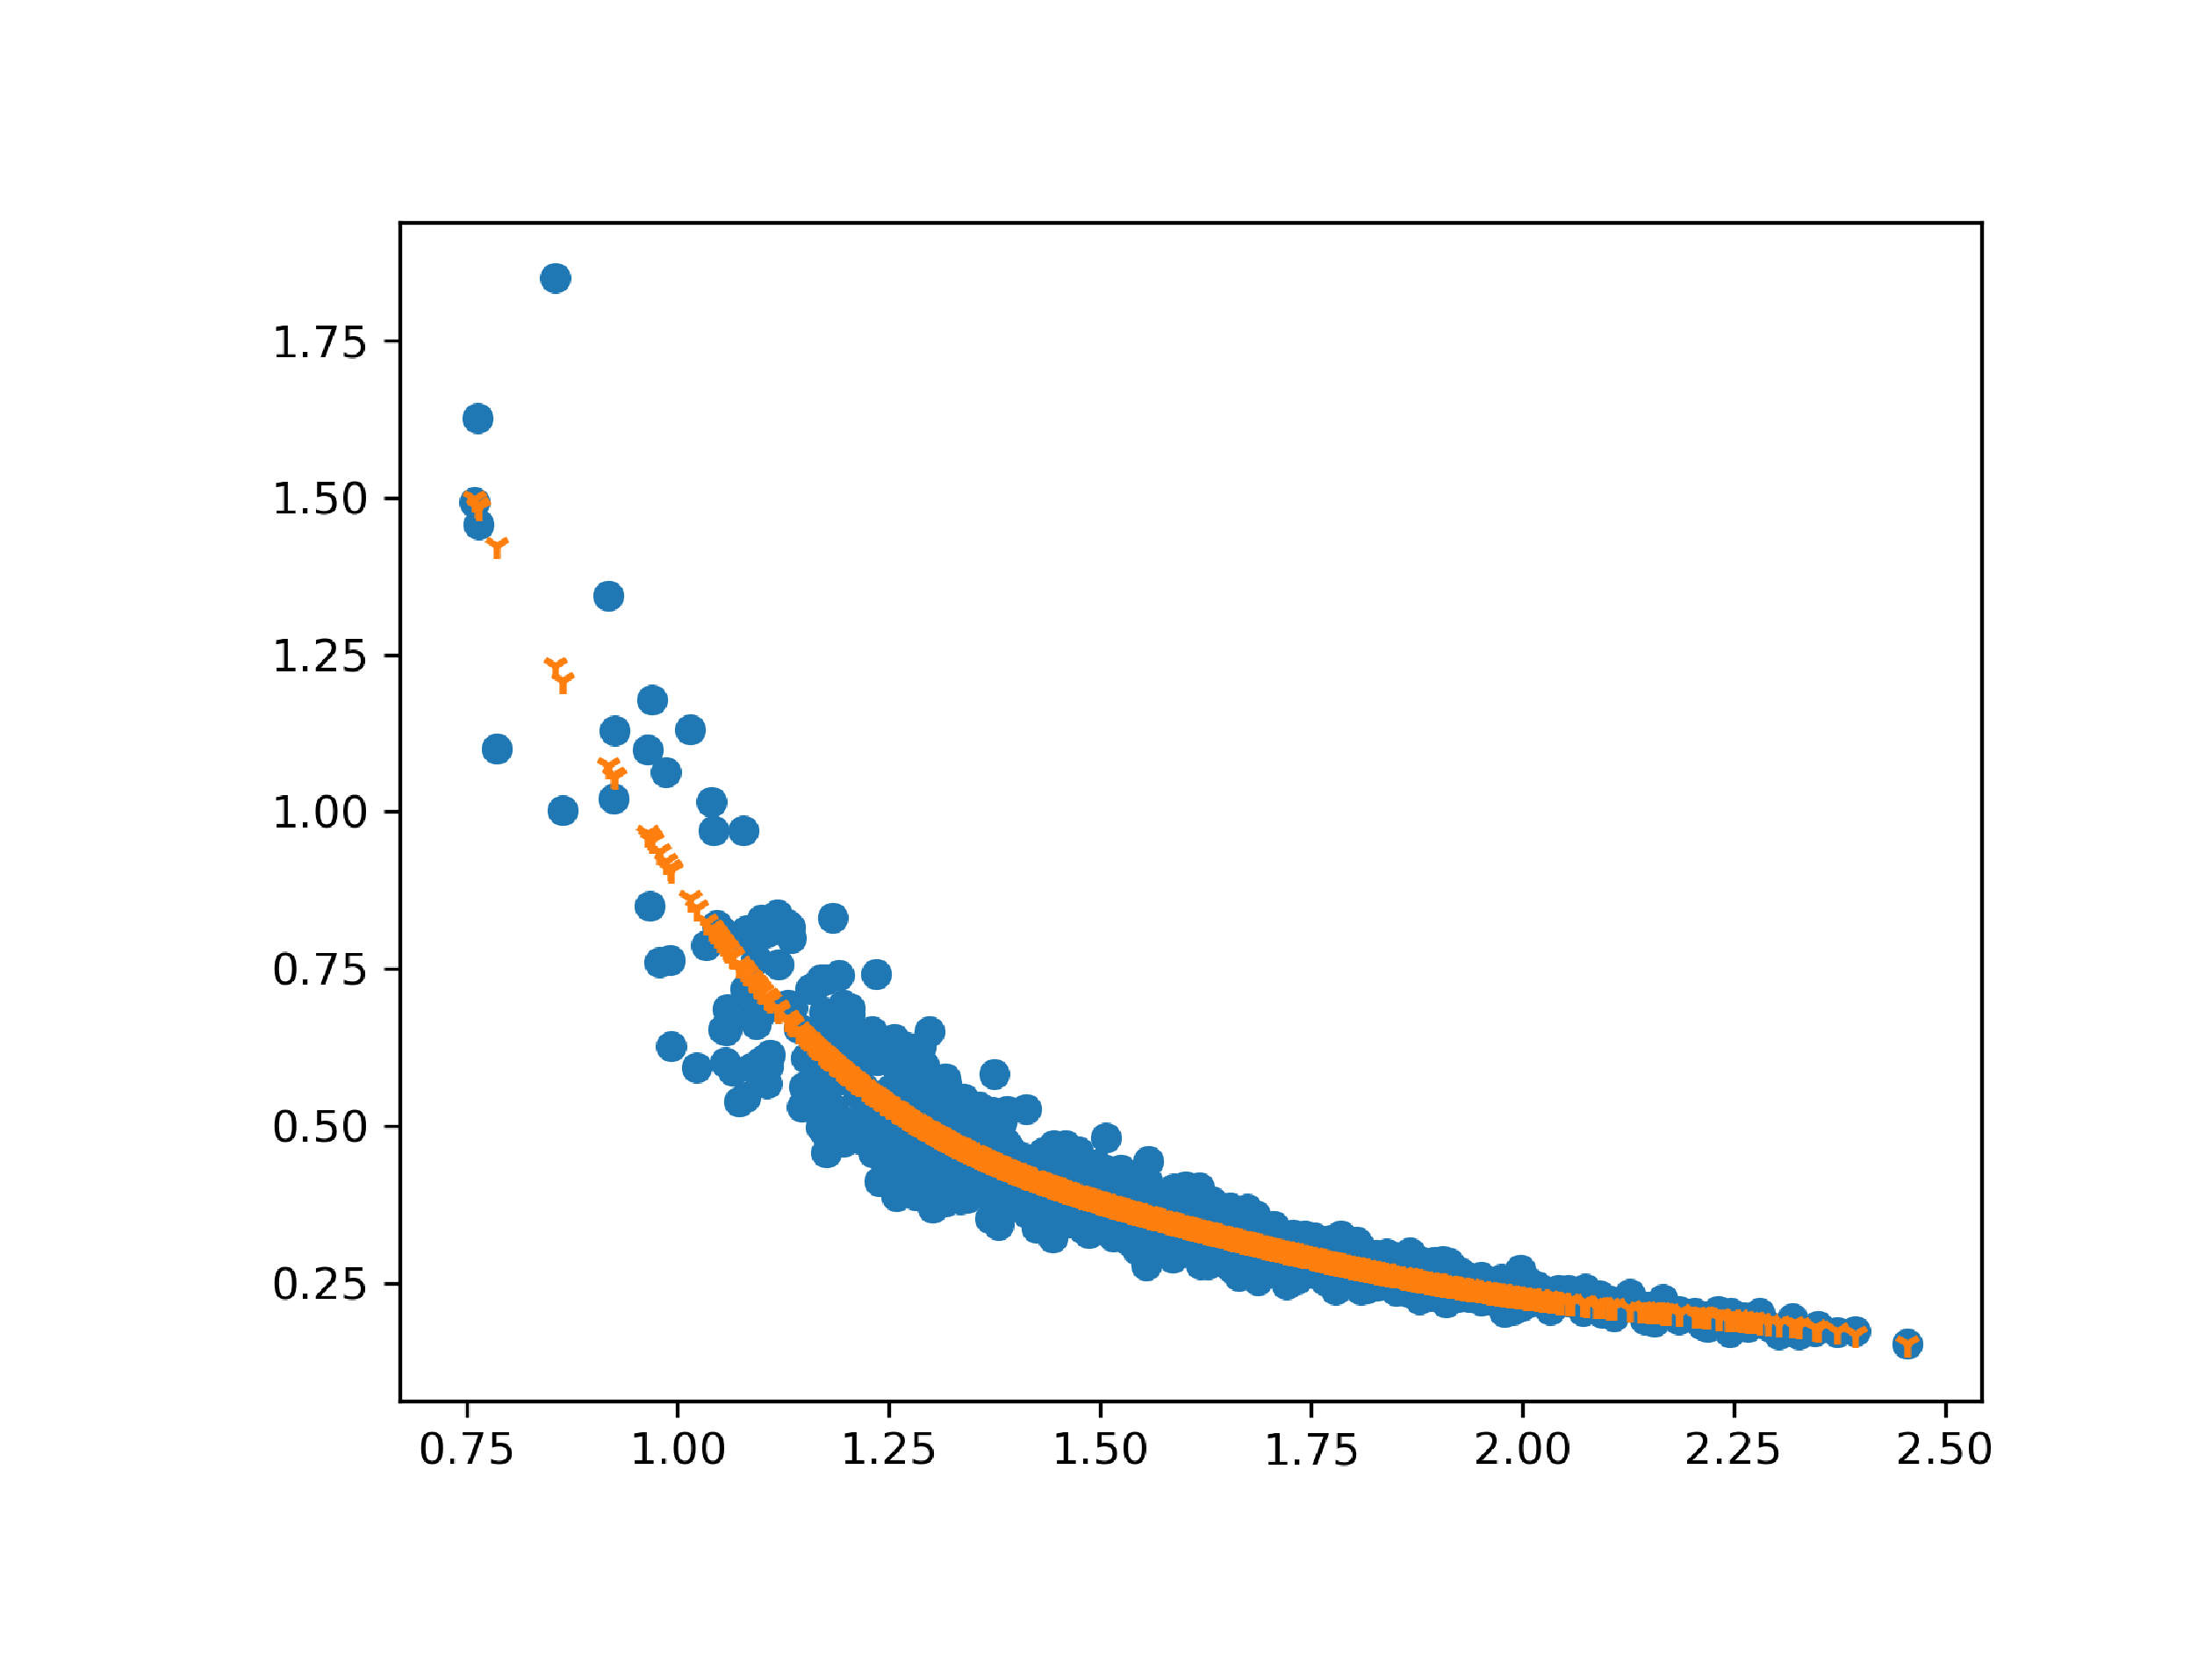

In [368]:
exp = exps_rows_df.loc[exp_hash].iloc[0].exp
pprint_color(exp.config)
for name, artifact in exp.artifacts.items():
    artifact.show()

In [246]:
# Latex table
save_table(mash_df.to_latex(), 'embeddings')

In [922]:
exp_row = exps_rows_df.reset_index().set_index('id').loc[174]
exp = exp_row.exp
pprint_color(exp.config)
for name, artifact in exp.artifacts.items():
    artifact.show()

{'exp_hash': '98fbe0c7937a63655132ed49296eb2741d5cd531',
 'gp_samples': 1000,
 'gp_use_derivatives': True,
 'model': {'kwargs': {'prob_model': {'kwargs': {'do_optimize': True,
                                                'kernel': {'kwargs': {'lengthscale': 1},
                                                           'name': 'GPyRBF'},
                                                'noise_prior': 0.01,
                                                'num_mcmc': 0},
                                     'name': 'GPModel'},
                      'transformer': {'kwargs': {'output_dim': 1},
                                      'name': 'ActiveSubspace'}},
           'name': 'TransformerModel'},
 'model_compare': False,
 'model_hash': 'c4612198048600b72e0df42ab9ee2503d443f7b1',
 'obj_func': {'kwargs': {'Alpha': [[0.78695576],
                                   [0.70777112],
                                   [0.34515641],
                                   [0.20288506],
              

### Step (non-diff)

In [485]:
exps_rows_df = df[df["tag"] == "step"].copy()
exps_rows_df['layers'] = exps_rows_df.apply(lambda row: row.config.model.kwargs.nn_kwargs.get('layers'), axis=1)
exps_rows_df['layers'] = exps_rows_df.apply(lambda row: tuple(row.layers) if row.layers is not None else (), axis=1)
exps_rows_df['n_iter'] = exps_rows_df.apply(lambda row: row.config.model.kwargs.get('n_iter'), axis=1)
exps_rows_df['learning_rate'] = exps_rows_df.apply(lambda row: row.config.model.kwargs.get('learning_rate'), axis=1)

exps_rows_df = aggregate_results(exps_rows_df)
view_df(exps_rows_df, indexes=["layers", "n_iter", "learning_rate"], f_as_col=True)

result.rmse          
f                                  SingleStep      Step
layers     n_iter learning_rate                        
(5, 5, 1)  1000   0.005              0.999982  1.691690
                  0.010              0.052260  4.680908
(5, 5, 2)  100    0.010              1.001269  2.589070
                  0.050            840.523340  0.716794
                  0.100              1.000440  0.615722
           1000   0.005              0.057299  0.781447
                  0.010          16952.832821  0.395039
                  0.050              8.177234  4.758531
                  0.100              2.930405  4.867066
           3000   0.005           6467.301657  0.451614
                  0.010                   NaN  3.097373
(50, 5, 2) 1000   0.005              0.058910  0.618225
                  0.010           2340.889341  0.378732

{'exp_hash': '0c6422ebe3f59d8416d731b0269d956c3338de45',
 'gp_samples': 1000,
 'gp_use_derivatives': False,
 'model': {'kwargs': {'learning_rate': 0.01,
                      'n_iter': 1000,
                      'nn_kwargs': {'layers': [5, 5, 1]},
                      'noise': None},
           'name': 'DKLGPModel'},
 'model_compare': False,
 'model_hash': 'f2f80042661a20cfc9b29793e986454810d8d184',
 'obj_func': {'kwargs': {'noise': 0.01}, 'name': 'SingleStep'},
 'seed': 716602897,
 'tag': 'step',
 'verbosity': {'bo_show_iter': 30, 'plot': False}}



Experiment(id=329, name=lions)

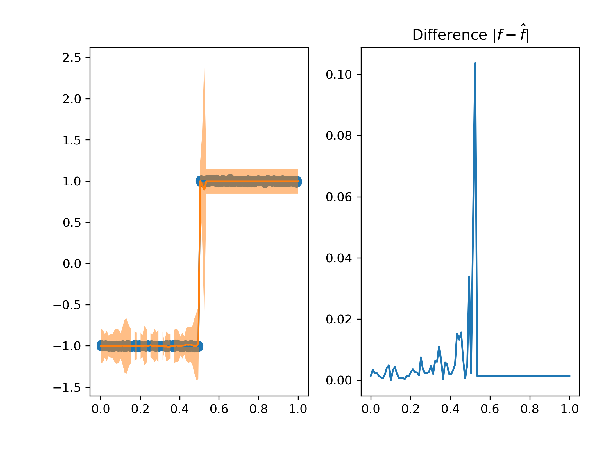

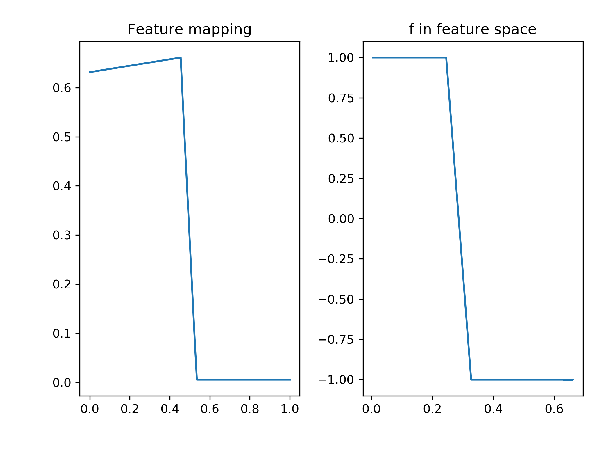

In [488]:
select_experiment_with_rmse(exps_rows_df, 0.052260)

{'exp_hash': '6bbfdd6b1b3c557815d0656e81dfcf0ccfc523b0',
 'gp_samples': 1000,
 'gp_use_derivatives': False,
 'model': {'kwargs': {'learning_rate': 0.005,
                      'n_iter': 1000,
                      'nn_kwargs': {'layers': [5, 5, 2]},
                      'noise': None},
           'name': 'DKLGPModel'},
 'model_compare': False,
 'model_hash': '357ff3110f7d000a029bf6cb682331525a375b01',
 'obj_func': {'kwargs': {'noise': 0.01}, 'name': 'SingleStep'},
 'seed': 863056964,
 'tag': 'step',
 'verbosity': {'bo_show_iter': 30, 'plot': False}}



Experiment(id=320, name=lions)

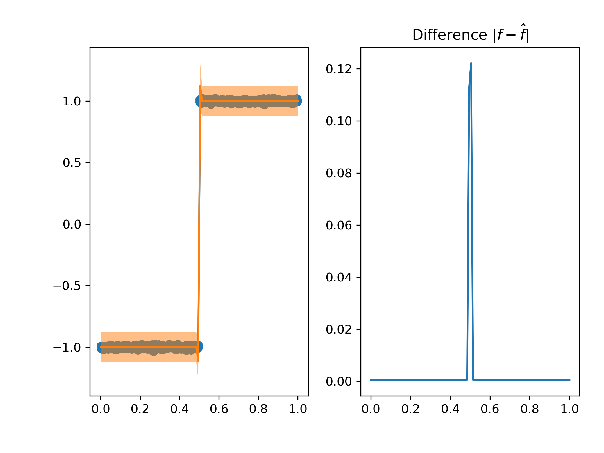

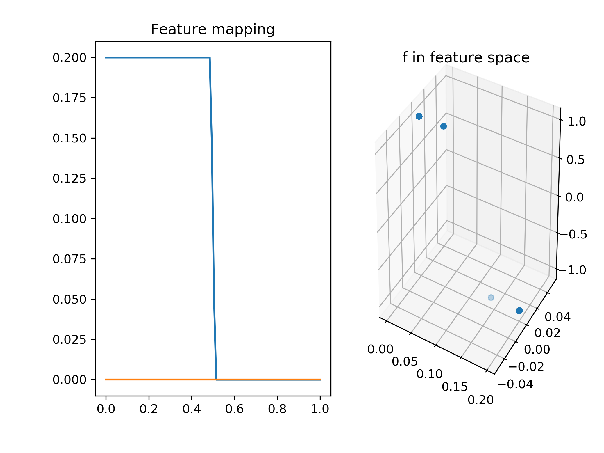

In [442]:
# This is the mapping we want (replicates manifold GP):
select_experiment_with_rmse(exps_rows_df, 0.057299)

### Genz1984

In [372]:
exps_rows_df = df[df["tag"] == "genz"].copy()
exps_rows_df

,acq,bo,config,exp,f,id,model,model2,model_hash,name,result.max_err,result.rmse,tag
exp_hash,,,,,,,,,,,,,
01a472c69d6536af485c1e1ac6d1e61123cd6236,None,False,{'exp_hash': '01a472c69d6536af485c1e1ac6d1e611...,"Experiment(id=230, name=lions)",GenzCornerPeak10,230,DKLGPModel,None,c87e307d72937479b09cceca238967c29c663217,DKLGPModel GenzCornerPeak10,4.745757e-12,1.178104e-13,genz
01dc4d606ca69b71b4ee3cf0e1583f7a17ce6a0f,None,False,{'exp_hash': '01dc4d606ca69b71b4ee3cf0e1583f7a...,"Experiment(id=223, name=lions)",GenzContinuous10,223,DKLGPModel,None,c87e307d72937479b09cceca238967c29c663217,DKLGPModel GenzContinuous10,7.575340e-03,2.855601e-04,genz
066baaf72daea88c307aa2581a2a47e1880b4bba,None,False,{'exp_hash': '066baaf72daea88c307aa2581a2a47e1...,"Experiment(id=235, name=lions)",GenzDiscontinuous2,235,DKLGPModel,None,c87e307d72937479b09cceca238967c29c663217,DKLGPModel GenzDiscontinuous2,1.771016e+02,1.752411e+01,genz
08c0c5fd95eadcb6476b5781fb0ae1e27895af74,None,False,{'exp_hash': '08c0c5fd95eadcb6476b5781fb0ae1e2...,"Experiment(id=289, name=lions)",GenzProductPeak10,289,DKLGPModel,None,1e8339e8056442bcc6b089696f8253f2f1909582,DKLGPModel GenzProductPeak10,4.805385e+12,1.857471e+11,genz
10272ceb7128a90ce5c4208938551cca503ebeb6,None,False,{'exp_hash': '10272ceb7128a90ce5c4208938551cca...,"Experiment(id=226, name=lions)",GenzGaussianPeak2,226,DKLGPModel,None,c87e307d72937479b09cceca238967c29c663217,DKLGPModel GenzGaussianPeak2,8.372847e-01,5.372471e-02,genz
18b3dc6346be6a7985a14789ab580508a45e6986,None,False,{'exp_hash': '18b3dc6346be6a7985a14789ab580508...,"Experiment(id=227, name=lions)",GenzGaussianPeak5,227,DKLGPModel,None,c87e307d72937479b09cceca238967c29c663217,DKLGPModel GenzGaussianPeak5,6.519223e-01,3.313262e-02,genz
1ee0b14aad04453864ecedeac7b7034ddef7b0cc,None,False,{'exp_hash': '1ee0b14aad04453864ecedeac7b7034d...,"Experiment(id=278, name=lions)",GenzDiscontinuous10,278,DKLGPModel,None,1e8339e8056442bcc6b089696f8253f2f1909582,DKLGPModel GenzDiscontinuous10,3.205519e+14,1.672765e+13,genz
203e2e417a35fbea54f65cb0fd478972b293fd20,None,False,{'exp_hash': '203e2e417a35fbea54f65cb0fd478972...,"Experiment(id=258, name=lions)",GenzContinuous10,258,DKLGPModel,None,43bca1cf06f48c30ac5800545624326f5476dcd4,DKLGPModel GenzContinuous10,7.139902e-03,2.967006e-04,genz
28c1bba738a19965cf89a885fb2dbf42031d2b21,None,False,{'exp_hash': '28c1bba738a19965cf89a885fb2dbf42...,"Experiment(id=282, name=lions)",GenzOscillatory2,282,DKLGPModel,None,1e8339e8056442bcc6b089696f8253f2f1909582,DKLGPModel GenzOscillatory2,1.500189e-01,8.999577e-03,genz


In [373]:
# Generate baseline models
baseline_df = create_baseline(exps_rows_df)
# SG_df = create_SG_df(exps_rows_df, depth=5, refinement_level=2, f_tol=1e-4)
full_df = pd.concat([exps_rows_df, baseline_df])#, SG_df])

In [374]:
full_df['f.D'] = full_df.apply(lambda r: r.config.obj_func.kwargs.get('D', -1), axis=1)
full_df['f.name'] = full_df.apply(lambda r: r.config.obj_func.name, axis=1)

In [375]:
# View ordered by name
view_df(full_df[full_df['model_hash'] == 'mean'], indexes=['model_hash', 'f.name', 'f.D'])

# Cont:          decreasing
# Corner:        decreasing 
# Dis:           increasing
# Gaussian peak: decreasing
# Oscilllation:  const
# Product:       increasing

# Since they behave so differently we have to normalize based on this. 

result.rmse
model_hash f.name            f.D f                                 
mean       GenzContinuous    2   GenzContinuous2       1.452256e-01
                             5   GenzContinuous5       1.764168e-02
                             10  GenzContinuous10      2.650118e-04
                             50  GenzContinuous50      2.708173e-22
           GenzCornerPeak    2   GenzCornerPeak2       4.391155e-02
                             5   GenzCornerPeak5       1.822012e-05
                             10  GenzCornerPeak10      1.576586e-13
                             50  GenzCornerPeak50     1.010577e-101
           GenzDiscontinuous 2   GenzDiscontinuous2    1.434056e+01
                             5   GenzDiscontinuous5    1.055088e+06
                             10  GenzDiscontinuous10   4.533489e+14
           GenzGaussianPeak  2   GenzGaussianPeak2     2.171404e-01
                             5   GenzGaussianPeak5     2.921402e-02
                             10  GenzGaussianPeak10    4.244904e-04
                             50  GenzGaussianPeak50    1.706025e-27
           GenzOscillatory   2   GenzOscillatory2      6.946951e-01
                             5   GenzOscillatory5      7.064540e-01
                             10  GenzOscillatory10     7.120985e-01
                             50  GenzOscillatory50     7.062545e-01
           GenzProductPeak   2   GenzProductPeak2      1.288124e+02
                             5   GenzProductPeak5      4.409724e+05
                             10  GenzProductPeak10     1.927695e+11

In [376]:
# Helper df to find baseline for the same function.
from runner import hash_subdict

full_df['f.hash'] = full_df.apply(lambda r: hash_subdict(r.config.obj_func), axis=1)
baseline_df['f.hash'] = baseline_df.apply(lambda r: hash_subdict(r.config.obj_func), axis=1)
baseline_hash_df = baseline_df[baseline_df.model == 'mean'].set_index('f.hash')

In [377]:
# normalize all `result.` with baseline
COLS = ['result.max_err', 'result.rmse']

normalized_full_df = full_df.copy()
for i in normalized_full_df.index:
    for col in COLS:
        baseline_rmse = baseline_hash_df.loc[normalized_full_df.loc[i]['f.hash']][col]
        normalized_full_df.at[i, col] = normalized_full_df.at[i, col] / baseline_rmse

In [378]:
# Cont:          decreasing easier 
# Corner:        decreasing easier
# Dis:           increasing harder
# Gaussian peak: decreasing easier
# Oscilllation:  const      
# Product:       increasing harder

# Small is better.

# less than one: smaller error than mean
# more than one: bigger error than mean (should not happend)

# What is a good scenario? Dimensionality should not effect our performance too much so constant normalized error.
# (make sure variance does not increase...)

# GenzDiscontinuous extreme bad (cannot capture in 1D embedding)
# GenzProductPeak finds good 1D embedding (is this true embedding though?)
# GenzCornerPeak horrible (im guessing active sampling is necessary...)

In [384]:
# View baseline-normalize df.
temp_df = normalized_full_df.copy()
temp_df['layers'] = temp_df.apply(lambda row: row.config.model.kwargs.nn_kwargs.get('layers'), axis=1)
temp_df['layers'] = temp_df.apply(lambda row: tuple(row.layers) if row.layers is not None else (), axis=1)

temp_df = temp_df[temp_df['model'] == 'DKLGPModel'][temp_df['layers'] == (100,50,2)]

view_df(temp_df, indexes=['model', 'layers', 'f.name', 'f.D'], cols=COLS)

 /Users/tmpethick/anaconda3/envs/lions/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning:Boolean Series key will be reindexed to match DataFrame index.


result.max_err  \
model      layers       f.name            f.D f                                     
DKLGPModel (100, 50, 2) GenzContinuous    2   GenzContinuous2            0.097554   
                                          5   GenzContinuous5            0.476933   
                                          10  GenzContinuous10           0.644125   
                                          50  GenzContinuous50           1.731569   
                        GenzCornerPeak    2   GenzCornerPeak2            0.147652   
                                          5   GenzCornerPeak5            0.494879   
                                          10  GenzCornerPeak10           0.066398   
                                          50  GenzCornerPeak50           0.365044   
                        GenzDiscontinuous 2   GenzDiscontinuous2         0.663304   
                                          5   GenzDiscontinuous5         0.678148   
                                          10  GenzDiscontinuous10        0.026085   
                        GenzGaussianPeak  2   GenzGaussianPeak2          0.089997   
                                          5   GenzGaussianPeak5          0.695139   
                                          10  GenzGaussianPeak10         1.510434   
                                          50  GenzGaussianPeak50         6.868691   
                        GenzOscillatory   2   GenzOscillatory2           0.126676   
                                          5   GenzOscillatory5           0.118611   
                                          10  GenzOscillatory10          1.975713   
                                          50  GenzOscillatory50          2.073522   
                        GenzProductPeak   2   GenzProductPeak2           0.018518   
                                          5   GenzProductPeak5           0.171543   
                                          10  GenzProductPeak10          1.076262   

                                                                   result.rmse  
model      layers       f.name            f.D f                                 
DKLGPModel (100, 50, 2) GenzContinuous    2   GenzContinuous2         0.088311  
                                          5   GenzContinuous5         0.891390  
                                          10  GenzContinuous10        1.119575  
                                          50  GenzContinuous50        1.814336  
                        GenzCornerPeak    2   GenzCornerPeak2         0.102434  
                                          5   GenzCornerPeak5        14.903109  
                                          10  GenzCornerPeak10        0.270547  
                                          50  GenzCornerPeak50        0.725466  
                        GenzDiscontinuous 2   GenzDiscontinuous2      0.364313  
                                          5   GenzDiscontinuous5      1.327753  
                                          10  GenzDiscontinuous10     0.047917  
                        GenzGaussianPeak  2   GenzGaussianPeak2       0.096376  
                                          5   GenzGaussianPeak5       0.868082  
                                          10  GenzGaussianPeak10      1.997456  
                                          50  GenzGaussianPeak50     13.617480  
                        GenzOscillatory   2   GenzOscillatory2        0.011323  
                                          5   GenzOscillatory5        0.028432  
                                          10  GenzOscillatory10       1.343386  
                                          50  GenzOscillatory50       1.270979  
                        GenzProductPeak   2   GenzProductPeak2        0.014513  
                                          5   GenzProductPeak5        0.116971  
                                          10  GenzProductPeak10       1.260569

{'exp_hash': '475d73cd8282745b673b692e55e0caf223953d36',
 'gp_samples': 1000,
 'gp_use_derivatives': False,
 'model': {'kwargs': {'learning_rate': 0.01,
                      'n_iter': 1000,
                      'nn_kwargs': {'layers': [100, 50, 2]},
                      'noise': 0.1},
           'name': 'DKLGPModel'},
 'model_compare': False,
 'model_hash': '43bca1cf06f48c30ac5800545624326f5476dcd4',
 'obj_func': {'kwargs': {'D': 2}, 'name': 'GenzDiscontinuous'},
 'seed': 258151272,
 'tag': 'genz',
 'verbosity': {'bo_show_iter': 30, 'plot': False}}



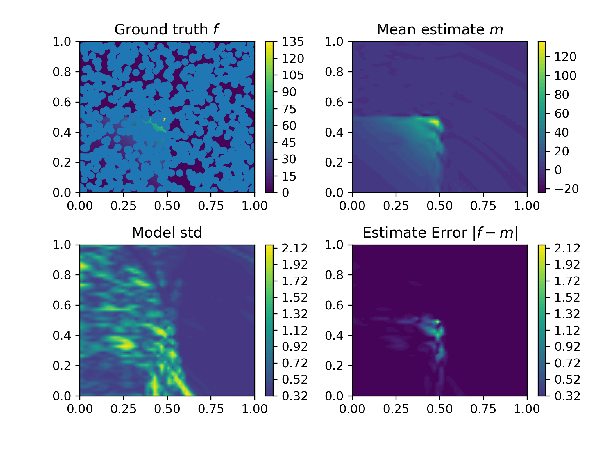

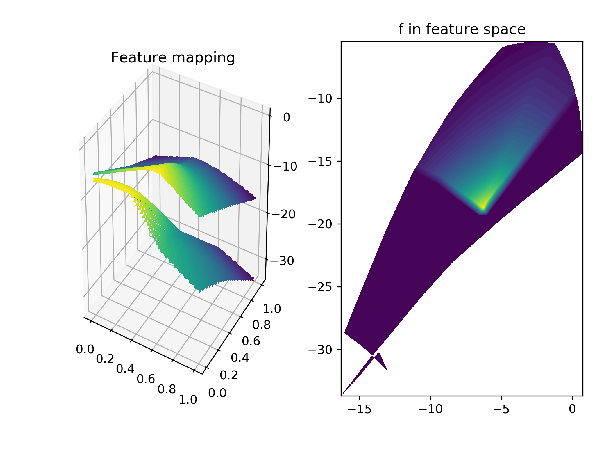

In [365]:
select_experiment_with_rmse(temp_df, 0.364678)

In [ ]:
# \label{table:genz}
save_table(non_stat_df.set_index('name').to_latex(escape=False), 'genz')

### Scalability

# (Temporary) Dumbster for scripting...

In [852]:
import numpy as np

D = 2
N_new = 5
N = 10

A = np.ones((N,D,D))
B = np.ones((N, N_new))
C = np.tensordot(B, A, axes=(0,0))
C.shape

(5, 2, 2)

/Users/tmpethick/anaconda3/envs/lions/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [684]:
# Dirty hack to filter out last experiment of curvature
exps_rows_df.exps.iloc['60519fa6dbfe5a80969a4b30ddd14cafbf68612f'] = exps_rows_df.exps.iloc['60519fa6dbfe5a80969a4b30ddd14cafbf68612f'][:-1]

TypeError: Cannot index by location index with a non-integer key

In [543]:
Lambda = np.identity(D)
(Lambda @ C)

array([[[10., 10.],
        [10., 10.]],

       [[10., 10.],
        [10., 10.]],

       [[10., 10.],
        [10., 10.]],

       [[10., 10.],
        [10., 10.]],

       [[10., 10.],
        [10., 10.]]])

In [558]:
N = 2
D = 2
N_new = 3
A = np.arange(N * D).reshape(N, D)
B = np.arange(N_new * D).reshape(N_new, D)

(A[:, None, :] - B[None, :, :])

array([[[ 0,  0],
        [-2, -2],
        [-4, -4]],

       [[ 2,  2],
        [ 0,  0],
        [-2, -2]]])

In [523]:
X_new = np.arange(5 * 2).reshape((5, 2))
X = np.arange(10 * 2).reshape((10, 2))

np.einsum('ik,jk->ijk', X_new, -X).shape

(5, 10, 2)

In [538]:
X = np.arange(5)
La = np.ones(5 * 5).reshape((5, 5))
np.einsum("ij,i->i", La, X)

array([ 0.,  5., 10., 15., 20.])

In [527]:
# Summing a and b
k_Xx = np.ones((N_new, N, D))
Ones = np.ones((N_new, N, D, D))
alpha = np.ones((N, 1))

np.einsum("ijkl,ijk->ikl", Ones, k_Xx * alpha)
np.einsum("jik,jik->ik", k_Xx, k_Xx)

array([[5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.]])

# Single experiment explorer

In [872]:
# Find the latest (using internal api of loader...)
exp = loader._runs.find().sort([('timestamp', -1)]).limit(1)[0]
exp = loader._make_experiment(exp)

In [66]:
exp

Experiment(id=1, name=lions)

In [17]:
#exp = loader.find_by_id(-1)

def artifact_to_numpy(artifact):
    return np.load(artifact.file)

X = artifact_to_numpy(exp.artifacts['X.npy'])
Y = artifact_to_numpy(exp.artifacts['Y.npy'])

bo_plots_dict = get_bo_plots(exp)
bo_plots = [bo_plots_dict[k] for k in sorted(bo_plots_dict.keys())]

KeyError: 'X.npy'

In [875]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(i=(0, len(bo_plots)-1))
def show_bo_plot(i):
    bo_plots[i].show()

interactive(children=(IntSlider(value=0, description='i', max=1), Output()), _dom_classes=('widget-interact',)…

In [877]:
exp.metrics['rmse'].plot()

KeyError: 'rmse'

## Reconstruct model

In [ ]:
# TODO:
# runner (in reconstruction mode)
# refit model

# Dangour Zone! (migrations and delete)

In [526]:
# Accces MongoDB directly
from pymongo import MongoClient
client = MongoClient(settings.MONGO_DB_URL)
db = client[settings.MONGO_DB_NAME]
col = db['runs']

In [768]:
query = {"config.tag": "certify-ExactDKL"}

In [207]:
########################### Delete Zone! ###############################

In [770]:
query = {}
loader.find(query)

[Experiment(id=1, name=lions),
 Experiment(id=2, name=lions),
 Experiment(id=3, name=lions),
 Experiment(id=4, name=lions),
 Experiment(id=5, name=lions),
 Experiment(id=6, name=lions),
 Experiment(id=7, name=lions),
 Experiment(id=8, name=lions),
 Experiment(id=9, name=lions),
 Experiment(id=10, name=lions),
 Experiment(id=11, name=lions),
 Experiment(id=12, name=lions),
 Experiment(id=13, name=lions),
 Experiment(id=14, name=lions),
 Experiment(id=15, name=lions),
 Experiment(id=16, name=lions),
 Experiment(id=17, name=lions),
 Experiment(id=18, name=lions),
 Experiment(id=19, name=lions),
 Experiment(id=20, name=lions),
 Experiment(id=21, name=lions),
 Experiment(id=22, name=lions),
 Experiment(id=23, name=lions),
 Experiment(id=24, name=lions),
 Experiment(id=25, name=lions),
 Experiment(id=26, name=lions),
 Experiment(id=27, name=lions),
 Experiment(id=28, name=lions),
 Experiment(id=29, name=lions),
 Experiment(id=30, name=lions),
 Experiment(id=31, name=lions),
 Experiment(id=32

In [771]:
for exp in loader.find(query):
    exp.delete(confirmed=True)